The prediction made in the previous section take into account uncertainties due to the fact that a Gaussian process
is stochastic but it doesn’t take into account any uncertainties in the values of the hyperparameters. 
This won’t matter if the hyperparameters are very well constrained by the data but in this case, 
many of the parameters are actually poorly constrained. To take this effect into account, 
we can apply prior probability functions to the hyperparameters and marginalize using Markov chain Monte Carlo (MCMC). 

In [2]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


In [180]:
xvalO = np.load("../GP_Paper/xvalO.npy")
yvalO = np.load("../GP_Paper/yvalO.npy")
xerrO = np.load("../GP_Paper/xerrO.npy")
xlowO = np.load("../GP_Paper/xlowO.npy")
xval = np.load("../GP_Paper/xval.npy")
yval = np.load("../GP_Paper/yval.npy")
xerr = np.load("../GP_Paper/xerr.npy")
smoothGPFit = np.load("../GP_Paper/initialGPfit.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

In [214]:
# function to display covariance matrices

def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        #ax2.plot(x, 2e6*np.exp(-(x/300)), c='g')
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

    '''
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    samples = np.random.multivariate_normal(modelMatrix[0], K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("X")
    '''


In [182]:

#background only plots
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  


    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
           # print nD, nB, pval, prob, zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) #/len(nB)
    return zvals, chi2

In [183]:
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)


In [184]:

def fit_gp_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0, 0, 0)
    #for i in range(num):
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e7+1
        init1 = np.random.random() * 200.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 6.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1e1, error_decay = 1e1, error_length = 1e-1, error_power = 1e-1, 
                   error_sub = 1e-1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 100), limit_p0 = (0,10), 
                   limit_p1 = (0, 20), limit_p2 = (-10,10)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 

    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs


class logLike_gp_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

In [185]:
def logLike_ind(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-yvalO)*(bkgFunc-yvalO) / bkgFunc) 
    

def logLike_3ff_emcee(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xvalO, p, xerrO)       
    logL = 0
    for ibin in range(len(yvalO)):
        data = yvalO[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler


def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

In [186]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
def fit_3ff_minuit(num,lnprob):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    # if Print:
    #     print "min LL",bestval
    #     print "best fit vals", bestargs
    return bestval, bestargs

### 3 parameter covariance matrix

In [187]:
##CHECK BOTH logLike_ind and logLike_3ff_emcee
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind)
print "I'm done"

Running first burn-in...
Running second burn-in
Running production
I'm done


(36000, 3)
[ 0.01476988  8.16364438 -5.26193492]


ValueError: Expected the given number of height ratios to match the number of rows of the grid

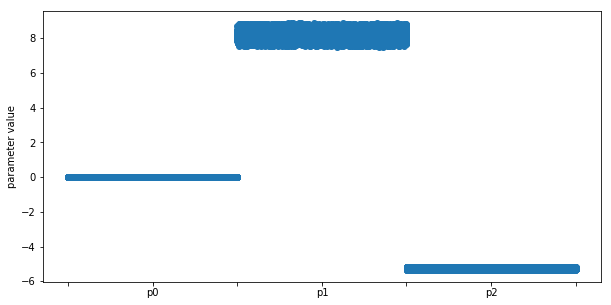

In [188]:

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)
### remove
yhist = [pvalues[i][0] for i in range(len(pvalues))]+[pvalues[i][1] for i in range(len(pvalues))]+[pvalues[i][2] for i in range(len(pvalues))]
binne = len(yhist)/3
xhist1 = list(100*np.random.random(binne))
xhist2 = list(100*np.random.random(binne)+100)
xhist3 = list(100*np.random.random(binne)+200)
xhist = xhist1+xhist2+xhist3


f, ax = plt.subplots(1,  figsize=(10,5))
ax.scatter(xhist, yhist)

ax.get_xaxis().set_major_formatter(ticker.NullFormatter())
# Customize minor tick labels
ax.get_xaxis().set_minor_locator(ticker.FixedLocator([50,150,250]))
ax.get_xaxis().set_minor_formatter(ticker.FixedFormatter(['p0','p1','p2']))
ax.tick_params(axis='x', labelsize=20)
ax.set_ylabel("parameter value")

plt.figure()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw = {'height_ratios':[1, 1, 1]}, figsize=(15,10))
#ax1.scatter([pvalues[i][0] for i in range(len(pvalues))], [pvalues[i][0] for i in range(len(pvalues))])
ax1.hist([pvalues[i][0] for i in range(len(pvalues))], 100)
ax1.set_xlabel("p0")
ax1.set_xlabel("p0")

ax2.hist([pvalues[i][1] for i in range(len(pvalues))], 100)
ax2.set_xlabel("p1")
ax2.set_xlabel("p1")

ax3.hist([pvalues[i][1] for i in range(len(pvalues))], 100)
ax3.set_xlabel("p2")
ax3.set_xlabel("p2")

In [189]:

modelMatrixa=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrixa[ip,:]= bkg
covMata = np.cov(modelMatrixa.T)
corMata = np.corrcoef(modelMatrixa.T)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


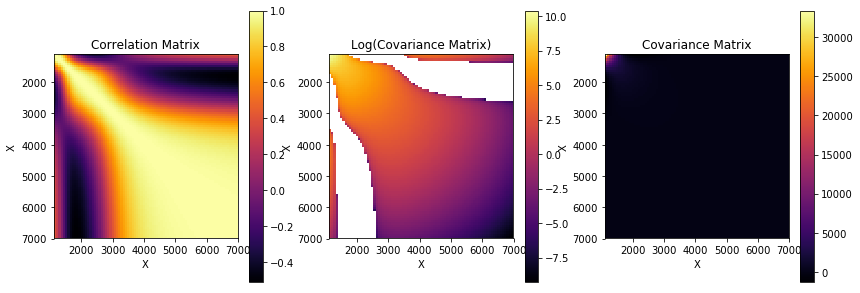

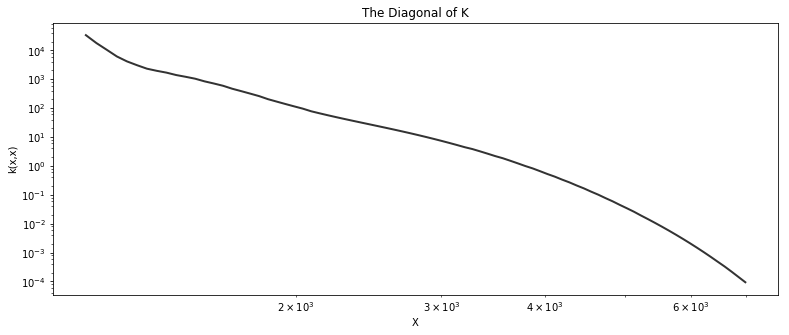

In [190]:
plot_cov(xvalO2D, corMata, covMata, False)

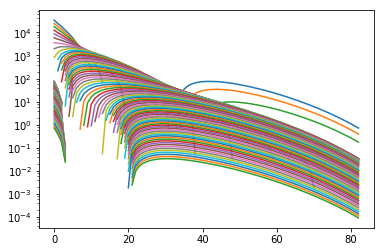

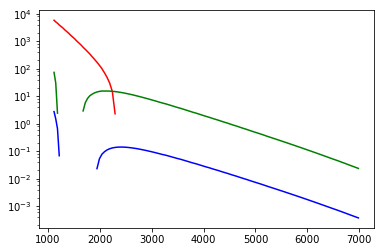

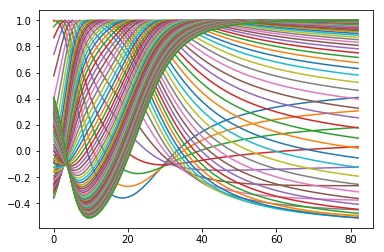

In [195]:
for i in range(len(covMata[1])):
    plt.plot(np.arange(len(covMata[1])),(covMata[i,:]))
plt.semilogy()
plt.figure()
plt.semilogy()
plt.plot(xvalO,(covMata[5,:]), c='r')
plt.plot(xvalO,(covMata[40,:]), c='g')
plt.plot(xvalO,(covMata[75,:]),c='b')
plt.figure()
for i in range(len(corMata[1])):
    plt.plot(np.arange(len(corMata[1])),(corMata[i,:]))

(36000, 83)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


[]

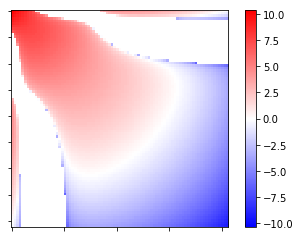

In [196]:
print modelMatrixa.shape
crop=0
maxVal = np.log(covMata[crop,crop])
plt.imshow(np.log(covMata[crop:,crop:]), cmap="bwr",vmin=-maxVal, vmax=maxVal, interpolation="nearest")
plt.colorbar()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

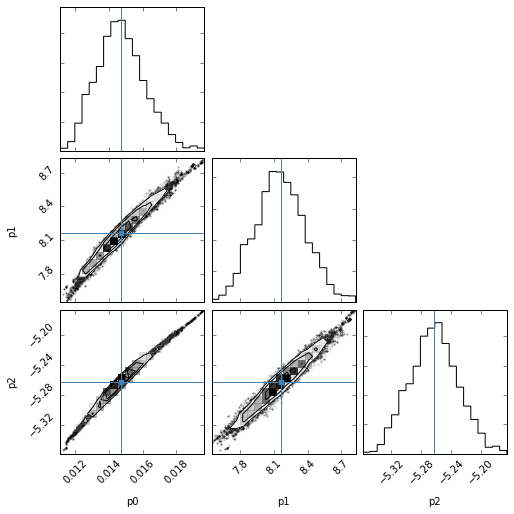

In [15]:
labels = ["p0", "p1", "p2"]
truth = pvalues.mean(axis=0)
fig = corner.corner(pvalues, truths=truth, labels=labels)


49639.0


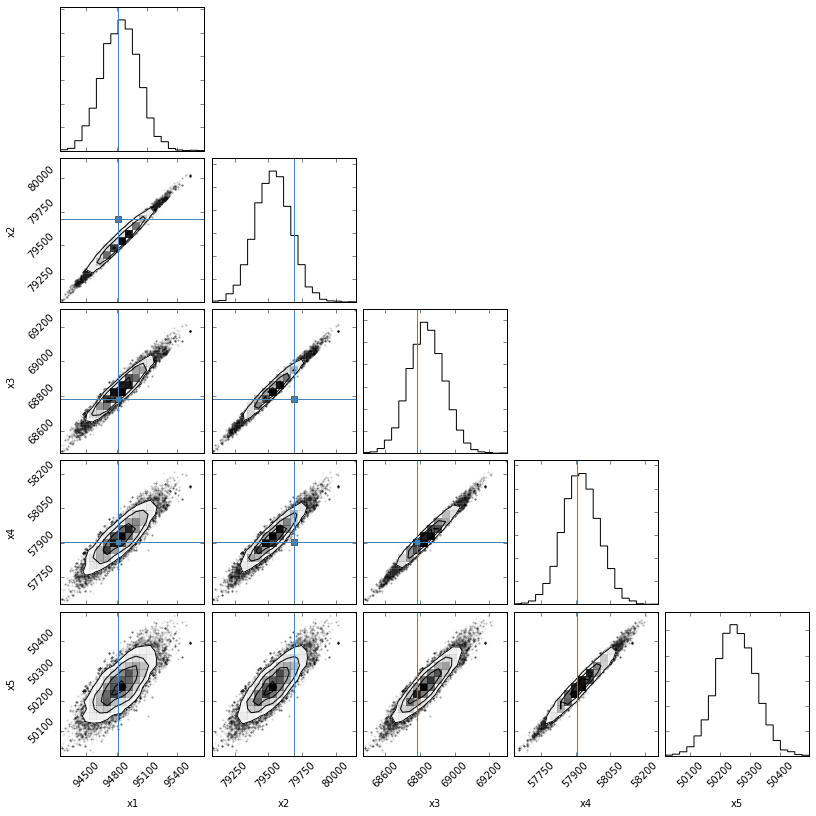

In [16]:
labels = ["x1", "x2", "x3", "x4", "x5"]
truth = yvalO[:5]
print yvalO[4]
fig = corner.corner(modelMatrix[:,:5], truths=truth, labels=labels)

['bin 3', 'bin 8', 'bin 13', 'bin 18', 'bin 23', 'bin 28', 'bin 33', 'bin 38', 'bin 43', 'bin 48', 'bin 53', 'bin 58', 'bin 63', 'bin 68']


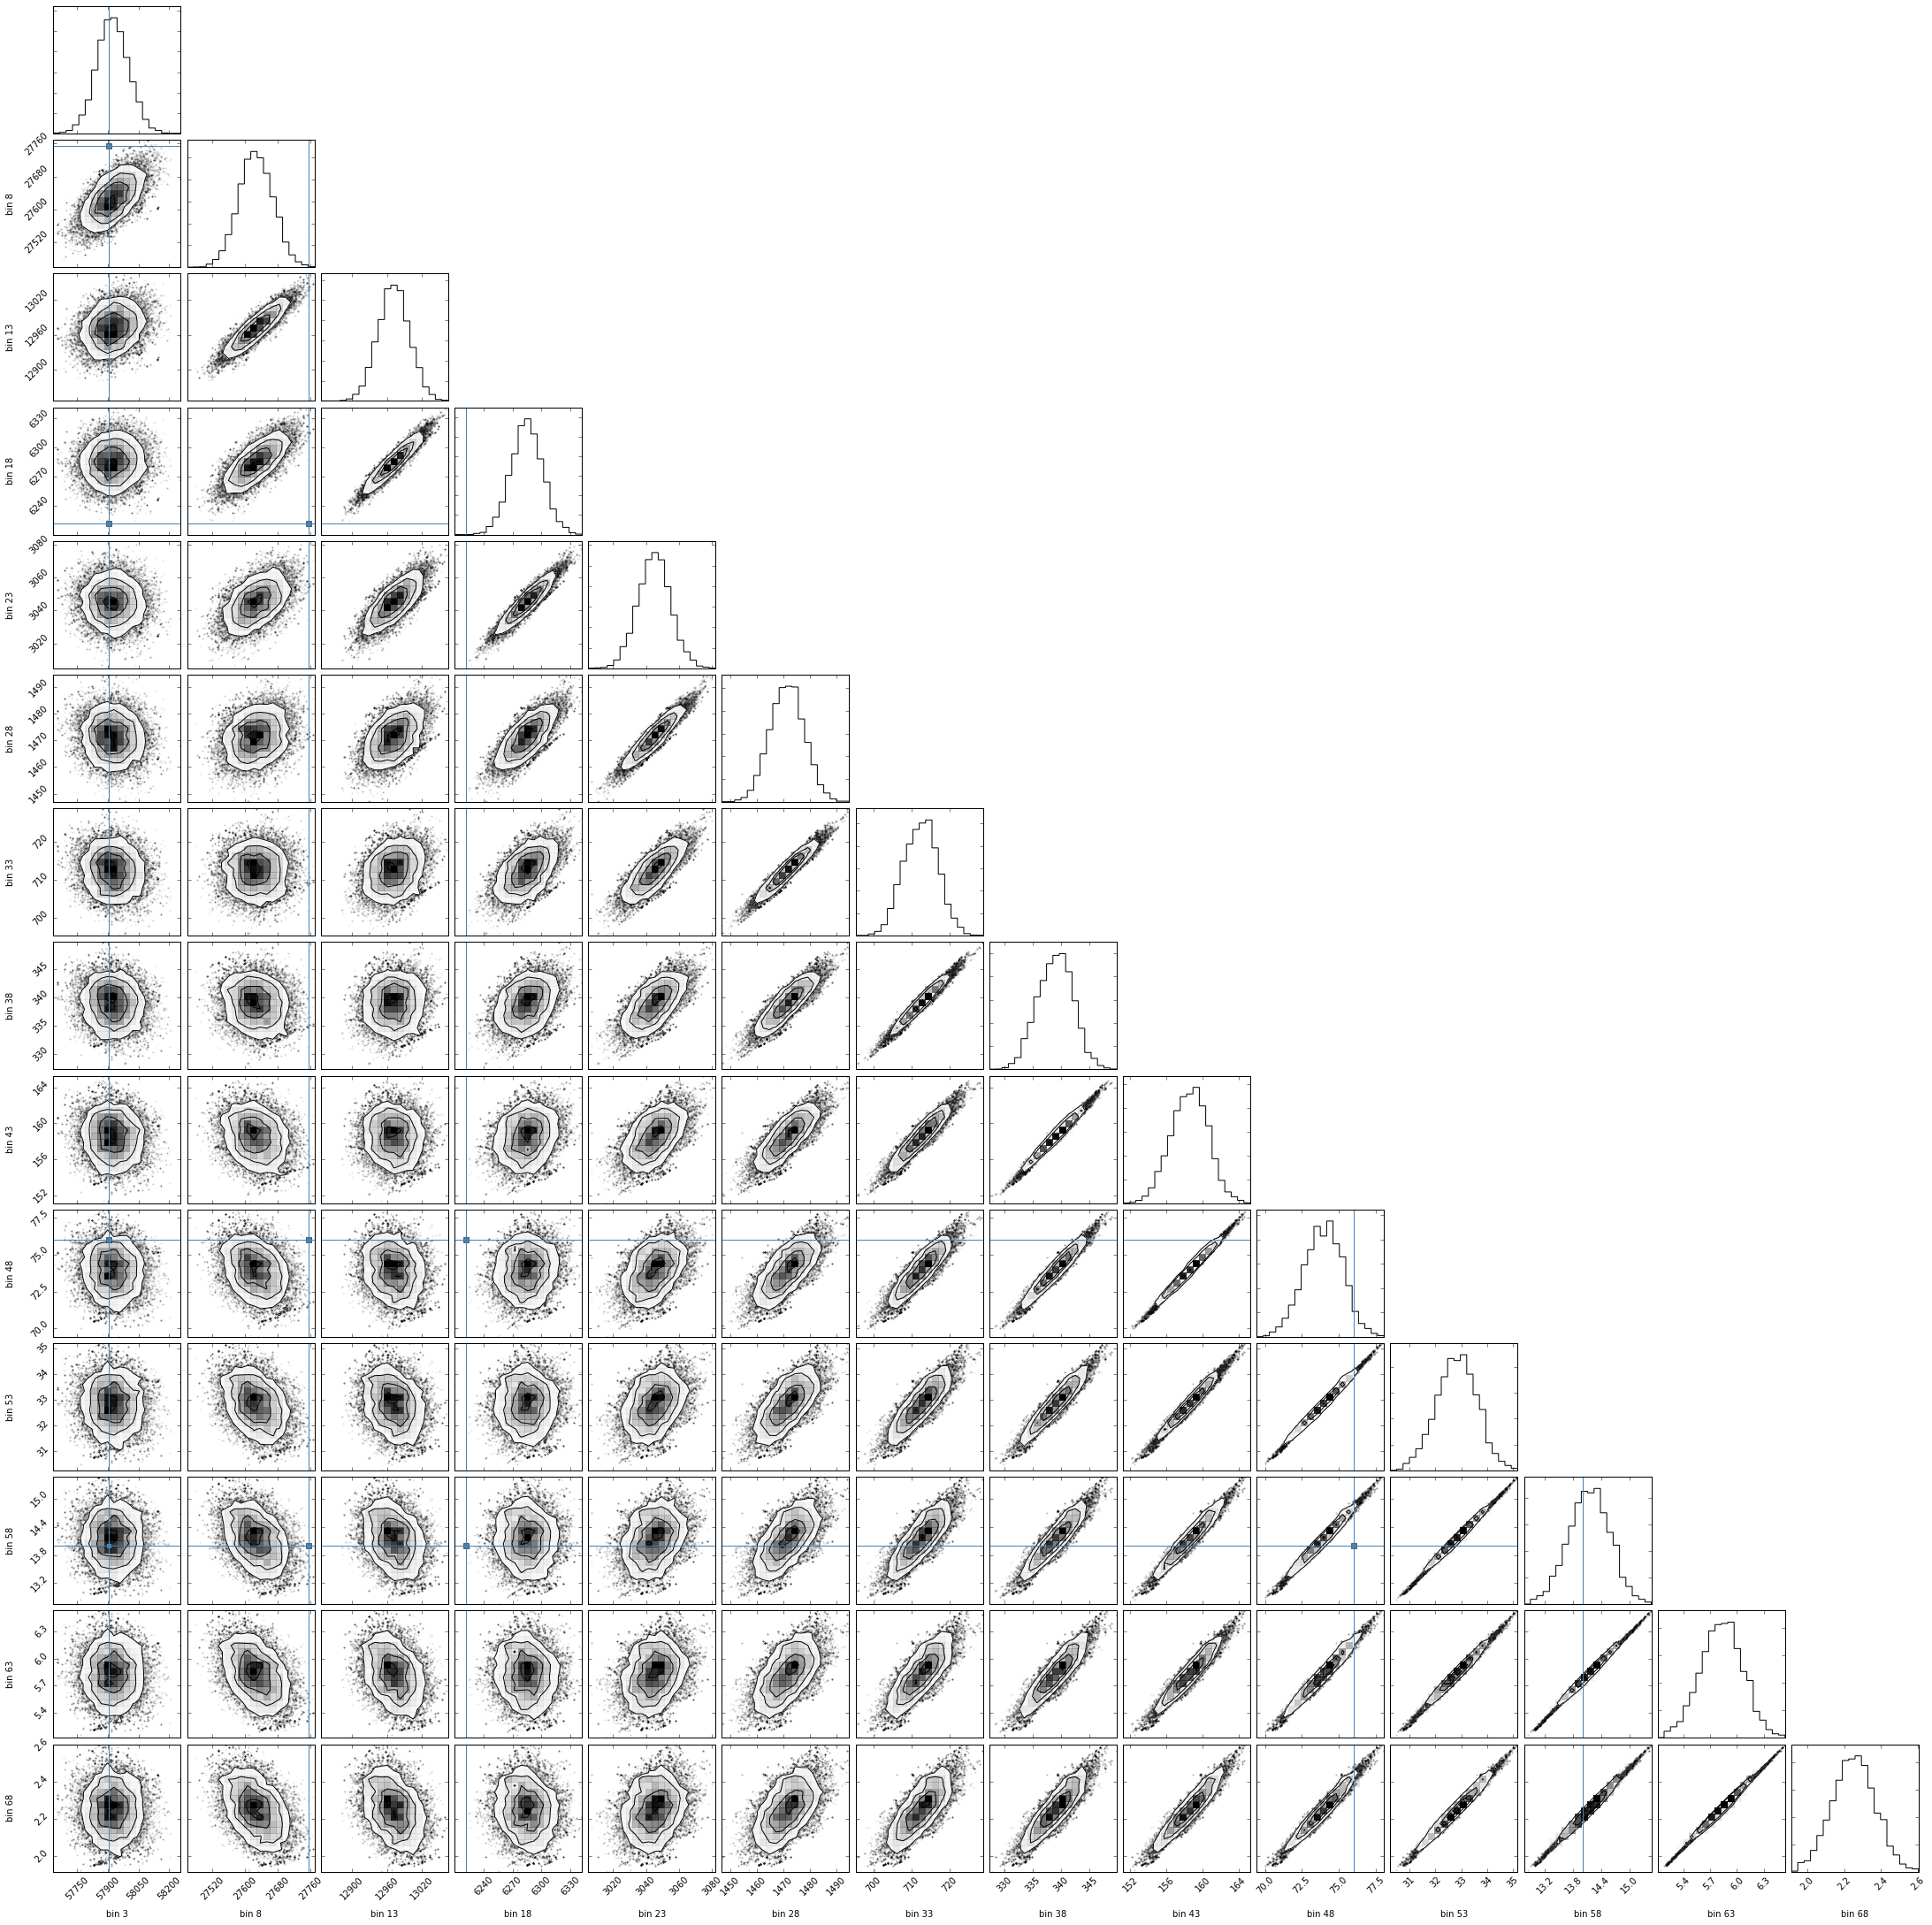

In [17]:
labels=map(str,np.arange(83)[-80:-10:5])
labels = ["bin " + s for s in labels]
print labels
truth = yvalO[-80:-10:5]
fig = corner.corner(modelMatrix[:,-80:-10:5], truths=truth, labels=labels)

### fit function or curve kernels


In [197]:
def fit_gp_curve(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1e1
        init1 = np.random.random() * 1e1
        init2 = np.random.random() * 1e1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  amp = init0, alpha = init1, beta = init2,
                  error_amp = 1e2, error_alpha = 1, error_beta = 1, 
                  limit_amp = (1, 1e50), limit_alpha = (-100, 100), limit_beta = (-100, 10000)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_curve:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, amp, alpha, beta):
        kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf
        

def fit_gp_ff(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 1.
        init2 = np.random.random() * 1. 
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                   p0 = init0, p1 = init1, p2 = init2, 
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, limit_p0 = (0,10), 
                   limit_p1 = (0, 10), limit_p2 = (-10,0)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_ff:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, p0, p1, p2):
        kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf

def fit_gp_curve_mean(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1e1
        init1 = np.random.random() * 1e1
        init2 = np.random.random() * 1e1
        init3 = np.random.random() * 1e1
        init4 = np.random.random() * 1e1
        init5 = np.random.random() * 1e1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  amp = init0, alpha = init1, beta = init2, p0 = init3, p1 = init4, p2 = init5,
                  error_amp=1e2, error_alpha=1, error_beta=1, error_p0=1, error_p1=1, error_p2=1,
                  limit_amp = (1, 1e50), limit_alpha = (-100, 100), limit_beta = (-100, 10000),
                  limit_p0 = (0,10), limit_p1 = (0, 10), limit_p2 = (-10,0)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_curve_mean:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, amp, alpha, beta, p0, p1, p2):
        kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_ff_mean(num, lnprob):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 1.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1e1
        init4 = np.random.random() * 1e1
        init5 = np.random.random() * 1e1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                   p0 = init0, p1 = init1, p2 = init2, p0m = init3, p1m = init4, p2m = init5,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p0m = 1e-2, 
                   error_p1m = 1e-2, error_p2m = 1e-2, limit_p0 = (0,10), limit_p1 = (0, 10), 
                   limit_p2 = (-10,0), limit_p0m = (0,10), limit_p1m = (0, 10), 
                   limit_p2m = (-10,0)) 
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    print "min LL", bestval
    print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp_ff_mean:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, p0, p1, p2, p0m, p1m, p2m):
        kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0m,p1m,p2m), self.x, self.xerr))
        except:
            return np.inf
        
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr




In [159]:
lnProb = logLike_gp_curve(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_curve(100, lnProb)
amp, alpha, beta = best_fit_gp
kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGP, covGP = gp.predict(yval, xvalO)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Exception Occured 
fcn is called with following arguments:
      amp = +95367401325985314648745470385925898987634688.000000
    alpha = +3.927889
     beta = +6.399491

  del sys.path[0]


NameError: global name 'CurvesKernel' is not defined

In [ ]:
samps = gp.sample_conditional(yval - model_gp(best_fit_gp[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrixgpexp=np.empty([samps.shape[0], xvalO.size])
print modelMatrixgpexp.shape
for ip, ps in enumerate(samps):
    modelMatrixgpexp[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMatgpexp = np.cov(modelMatrixgpexp.T)
corMatgpexp = np.corrcoef(modelMatrixgpexp.T)
plot_cov(xvalO2D, corMatgpexp, covMatgpexp, False)
makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgpexp[:100]).tolist(), "", ymax = 2e5)

chi2 78.3191240162


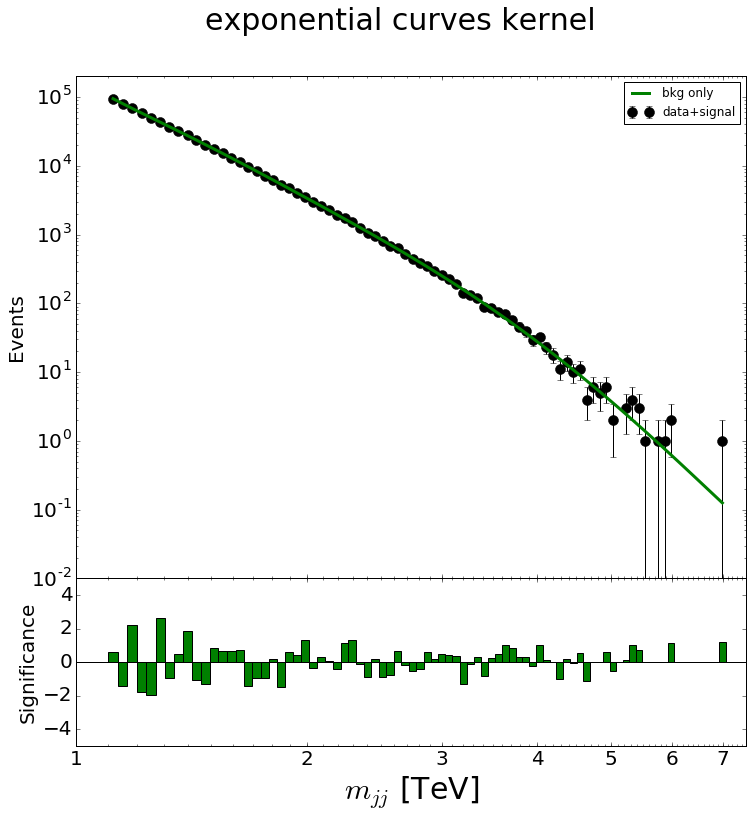

In [20]:
makePrettyPlots(xvalO, yvalO, meanGP, "exponential curves kernel")

In [21]:
lnProb = logLike_gp_curve_mean(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_curve_mean(100, lnProb)
amp, alpha, beta, p0, p1, p2 = best_fit_gp
kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp((p0,p1,p2),xval, xerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)


min LL 310.696328018
best fit vals (1.665334536937735e+34, 9.069789723994305, 0.19298244392848574, 0.01661552861537352, 8.463610832326044, -5.222485204097102)


In [ ]:
samps = gp.sample_conditional(yval - model_gp(best_fit_gp[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrixgpexpm=np.empty([samps.shape[0], xvalO.size])
print modelMatrixgpexpm.shape
for ip, ps in enumerate(samps):
    modelMatrixgpexpm[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMatgpexpm = np.cov(modelMatrixgpexpm.T)
corMatgpexpm = np.corrcoef(modelMatrixgpexpm.T)
plot_cov(xvalO2D, corMatgpexpm, covMatgpexpm, False)
makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgpexpm[:100]).tolist(), "", ymax = 2e5)

chi2 65.5743018296


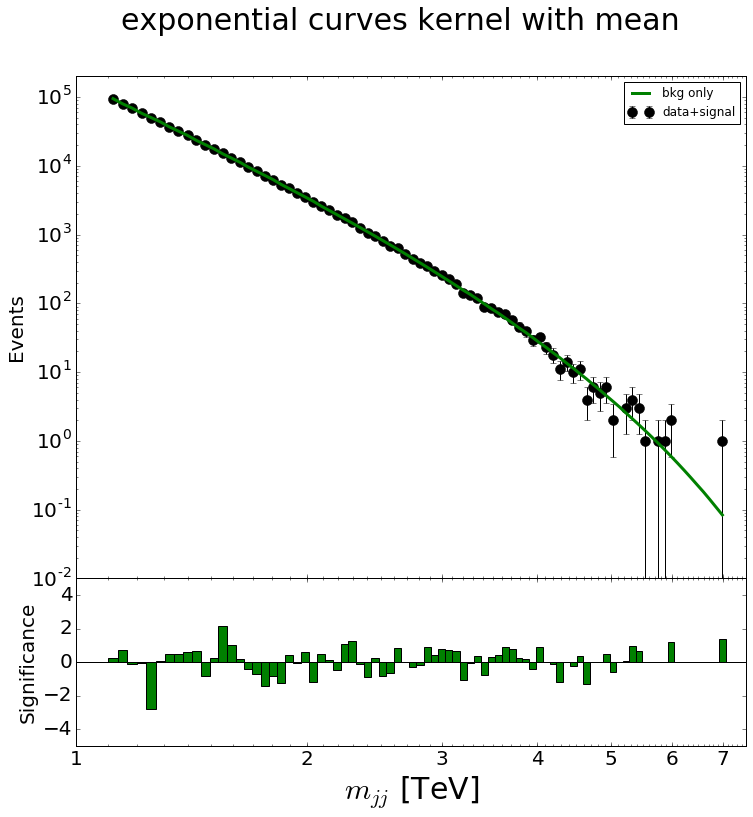

In [22]:
makePrettyPlots(xvalO, yvalO, meanGP, "exponential curves kernel with mean")

In [23]:
lnProb = logLike_gp_ff(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_ff(100, lnProb)
p0, p1, p2 = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGP, covGP = gp.predict(yval, xvalO)

min LL 338.201243114
best fit vals (1.7705062239653442, 7.443030762016896, -4.703544558842086)


In [ ]:
samps = gp.sample_conditional(yval - model_gp(best_fit_gp[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrixgpff=np.empty([samps.shape[0], xvalO.size])
print modelMatrixgpff.shape
for ip, ps in enumerate(samps):
    modelMatrixgpff[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMatgpff = np.cov(modelMatrixgpff.T)
corMatgpff = np.corrcoef(modelMatrixgpff.T)
plot_cov(xvalO2D, corMatgpff, covMatgpff, False)
makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgpff[:100]).tolist(), "", ymax = 2e5)

chi2 101.629036396


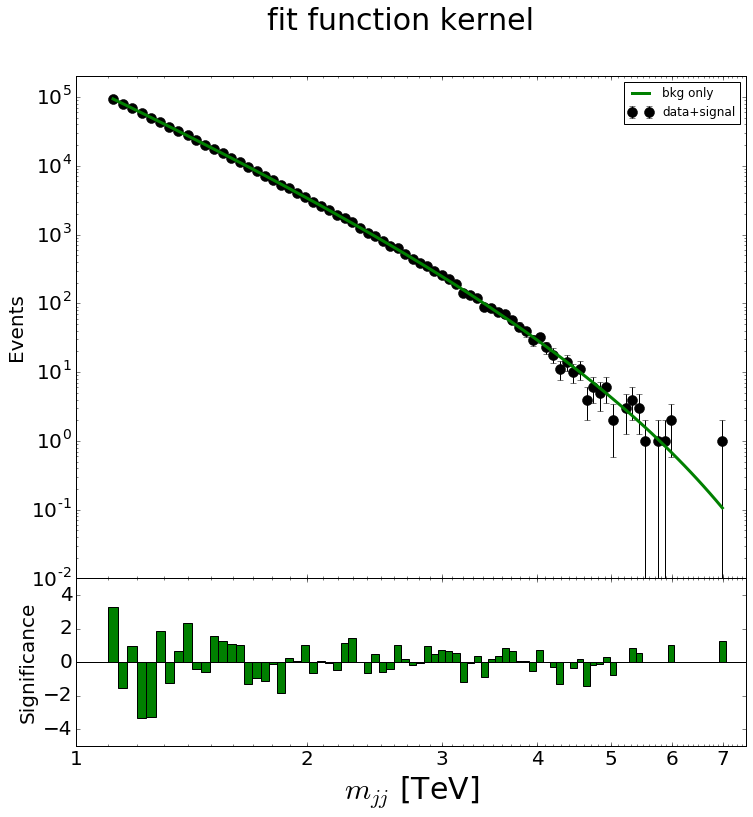

In [24]:
makePrettyPlots(xvalO, yvalO, meanGP, "fit function kernel")

In [25]:
lnProb = logLike_gp_ff_mean(xval,yval, xerr)
bestval, best_fit_gp = fit_gp_ff_mean(100, lnProb)
p0, p1, p2,p0m, p1m, p2m = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp((p0m,p1m,p2m),xval, xerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0m,p1m,p2m),xerrO)
testing = meanGP

min LL 310.696327398
best fit vals (0.003595765756010949, 8.0899289880578, -0.21055021252480266, 0.01661385002339366, 8.463385928797289, -5.2225183950763405)


In [ ]:
samps = gp.sample_conditional(yval - model_gp(best_fit_gp[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrixgpffm=np.empty([samps.shape[0], xvalO.size])
print modelMatrixgpffm.shape
for ip, ps in enumerate(samps):
    modelMatrixgpffm[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMatgpffm = np.cov(modelMatrixgpffm.T)
corMatgpffm = np.corrcoef(modelMatrixgpffm.T)
plot_cov(xvalO2D, corMatgpffm, covMatgpffm, False)
makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgpffm[:100]).tolist(), "", ymax = 2e5)

chi2 65.5719259855


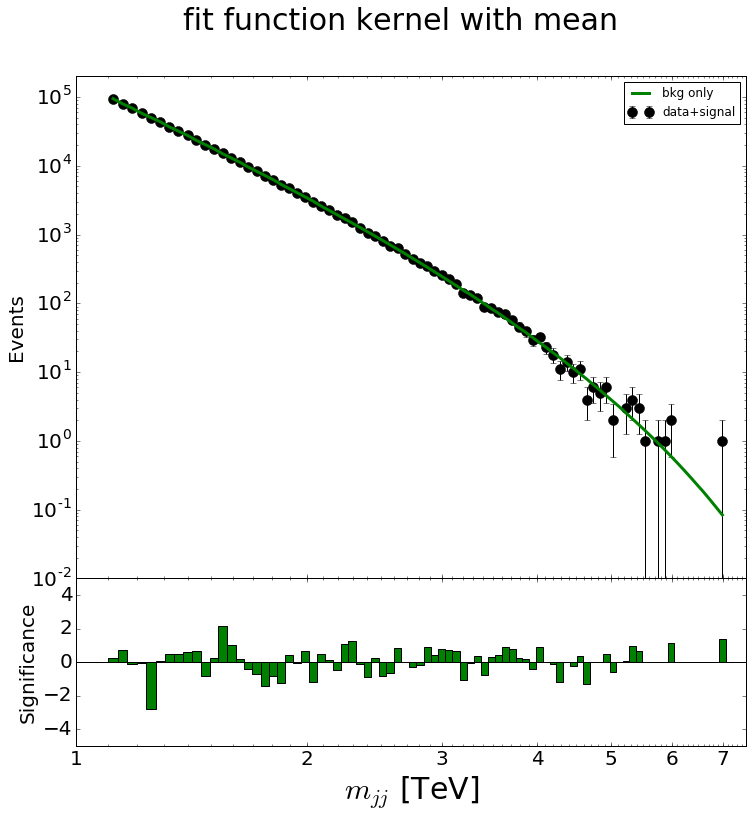

In [26]:
makePrettyPlots(xvalO, yvalO, meanGP, "fit function kernel with mean")

### other kernels at higher luminosity

In [27]:
highLum = makeToys(testing, 5, 50)
ytoy, xtoy, xtoyerr = removeZeros(highLum[0])

min LL 688.362673853
best fit vals (6.536460818627739e+49, 15.697714280165314, 10.611975394733776)
chi2 514.490175937


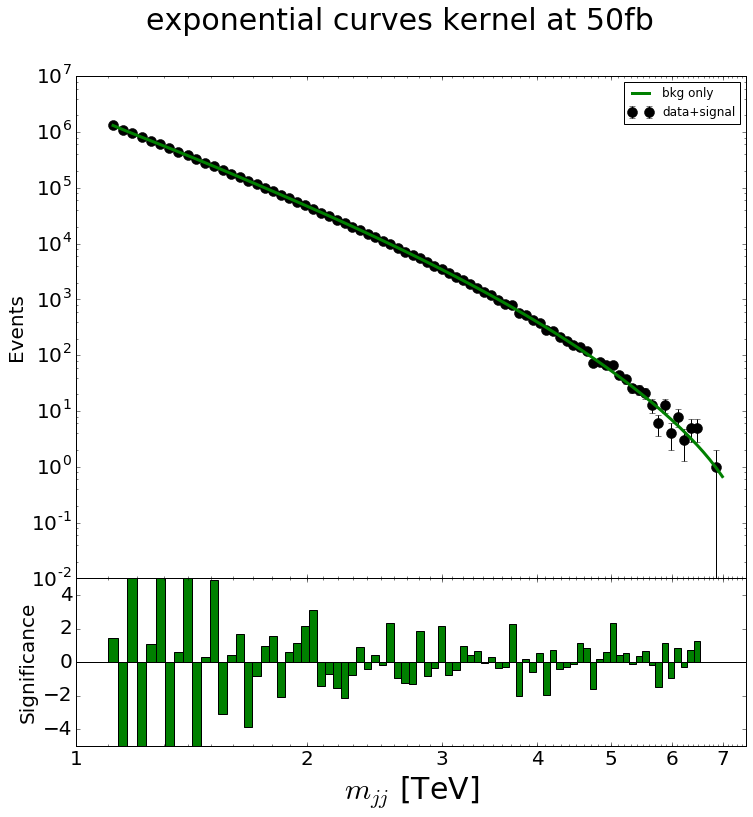

In [28]:
lnProb = logLike_gp_curve(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_curve(100, lnProb)
amp, alpha, beta = best_fit_gp
kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGP, covGP = gp.predict(ytoy, xvalO)
makePrettyPlots(xvalO, highLum[0], meanGP, "exponential curves kernel at 50fb", 'g', 10e6)

min LL 439.333218936
best fit vals (1.4266882120139713e+40, 17.85296817267607, 13.443655710944057, 0.22672807652021287, 8.425955294001529, -5.228536220871868)
chi2 92.6945897832


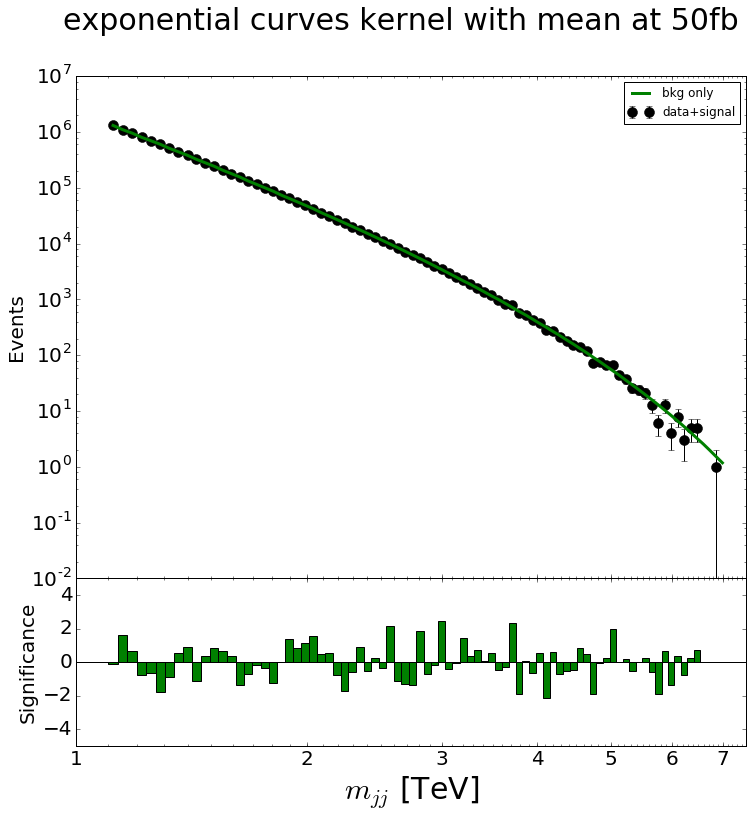

In [29]:
lnProb = logLike_gp_curve_mean(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_curve_mean(100, lnProb)
amp, alpha, beta, p0, p1, p2 = best_fit_gp
kernel = amp*CurvesKernel(alpha=alpha, beta=beta)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
makePrettyPlots(xvalO, highLum[0], meanGP, "exponential curves kernel with mean at 50fb",'g',10e6)

min LL 759.582808479
best fit vals (9.999999999703505, 7.412160693317702, -4.70879356989693)
chi2 702.752895874


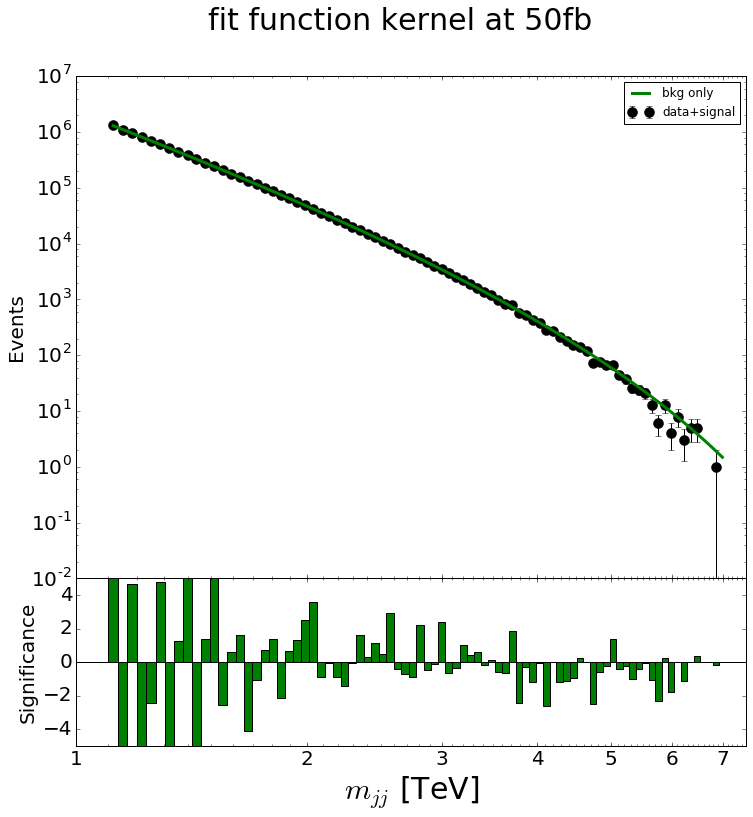

In [30]:
lnProb = logLike_gp_ff(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_ff(100, lnProb)
p0, p1, p2 = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGP, covGP = gp.predict(ytoy, xvalO)
makePrettyPlots(xvalO, highLum[0], meanGP, "fit function kernel at 50fb", 'g', 10e6)

min LL 438.273022384
best fit vals (9.999492241937013, 3.865545616990963, -0.5688221763009409, 0.2196505073619609, 8.345743681047534, -5.238606149948356)
chi2 92.0817702802


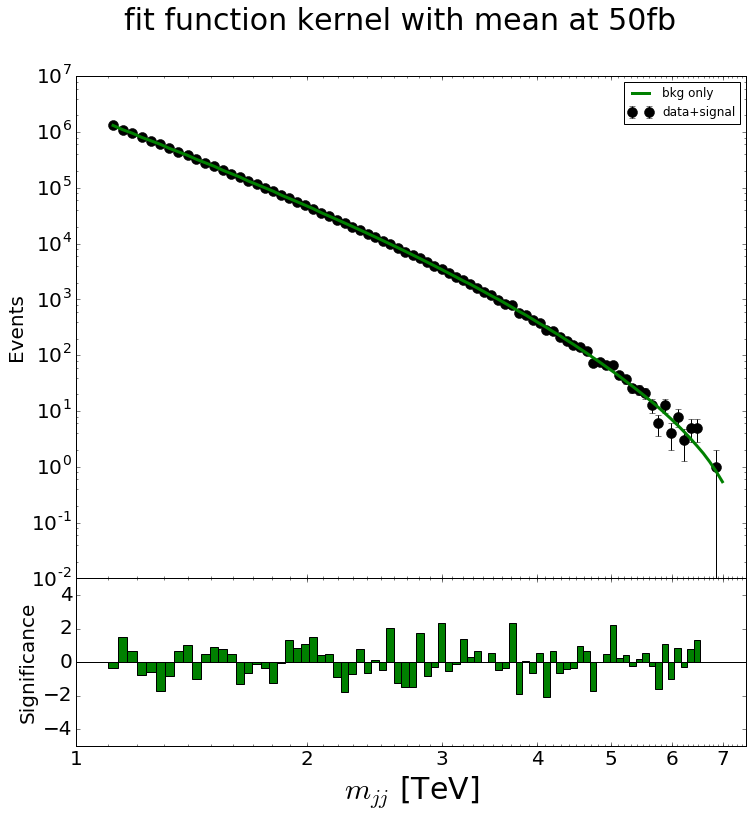

In [31]:
lnProb = logLike_gp_ff_mean(xtoy,ytoy, xtoyerr)
bestval, best_fit_gp = fit_gp_ff_mean(100, lnProb)
p0, p1, p2,p0m, p1m, p2m = best_fit_gp
kernel = FitFunctionKernel(p0=p0, p1=p1, p2=p2)
gp = george.GP(kernel)
gp.compute(xtoy, np.sqrt(ytoy))
meanGPp, covGP = gp.predict(ytoy - model_gp((p0m,p1m,p2m),xtoy, xtoyerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,(p0m,p1m,p2m),xerrO)
makePrettyPlots(xvalO, highLum[0], meanGP, "fit function kernel with mean at 50fb", 'g', 10e6)

### Spurious signals with MC

In [19]:
def makePrettyPlots_basic(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    poisErr = ax2.plot(xs, np.sqrt(ys), ls="-", marker=None, c="black", label="MC Poisson Errors")
    fitDiff = ax2.plot(xs, (ys-bkgs), ls="-", marker=None, c=col, label="MC - Fit")
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5e2, 5e2])
    ax2.legend()
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

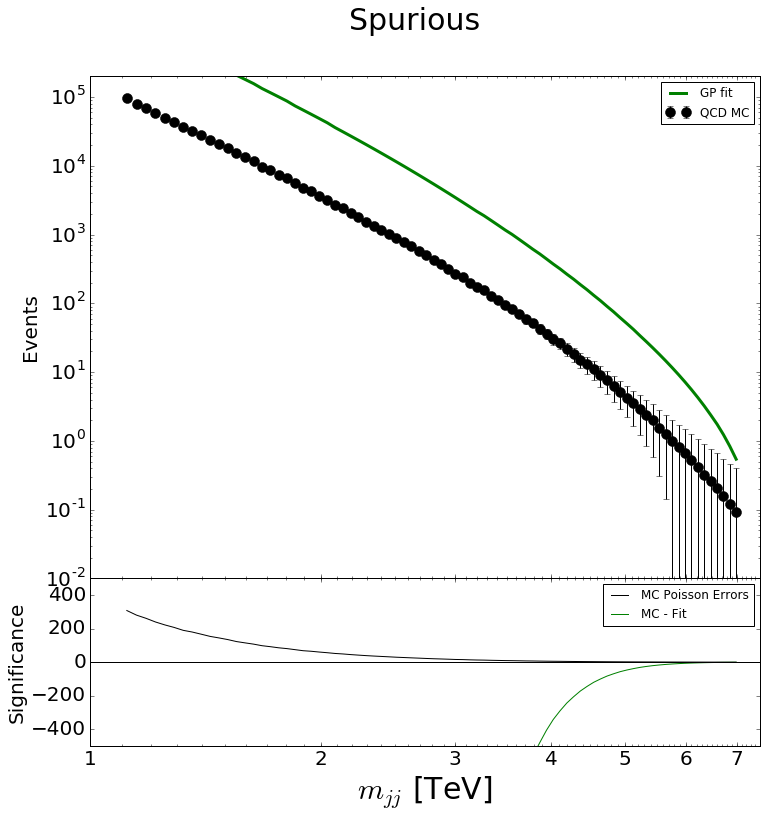

[ -5.13917840e-03   7.83717278e-03   1.12922756e-03   2.94976912e-03
  -7.01032534e-04   8.30142296e-03   1.65931545e-02  -1.51249953e-02
  -6.35184037e-03  -1.03017153e-02  -3.93473687e-02  -3.26576212e-02
   1.41559499e-04  -1.69154708e-02  -2.98797072e-02  -1.88227388e-02
  -3.86328625e-02  -3.81397115e-02  -5.66883778e-02  -6.39466916e-02
  -6.50539307e-03  -5.35352171e-02  -3.80112329e-02  -7.34983546e-02
  -4.24876338e-02  -7.19540730e-02  -6.61172628e-02  -2.97510663e-02
  -1.98862402e-02  -6.23604520e-02  -9.77679167e-02  -7.14342192e-02
  -9.84842981e-02  -1.12010669e-01  -6.18895750e-02  -9.93948031e-02
  -1.04943367e-01  -9.36109998e-02  -5.65075318e-02  -7.57240354e-02
  -2.11805142e-02  -8.17114995e-02  -4.67199236e-02  -1.75331654e-01
  -1.42800754e-01  -7.48177795e-02  -1.89292378e-01  -7.43497161e-02
  -9.00347890e-02  -2.96364617e-02  -9.11733671e-03  -1.18971376e-01
  -8.87449713e-02  -1.92803836e-01   4.74411726e-02  -1.38131673e-01
  -1.77519318e-01  -4.04298795e-01

In [33]:
makePrettyPlots_basic(xvalO, mcqcd, meanGP, "Spurious")
## Spurious signals - QCD MC (smooth) compared to fit. make sure no difference between QCD 
## QCD background fit look like signals or could cover signals
print (yvalO-mcqcd)/mcqcd

### LLH Ratio with and without constraint terms

In [34]:
def LLR_P(mean, data):
    return data*np.log(mean/data)-mean+data

([<matplotlib.axis.XTick at 0x139816910>,
 <a list of 2 Text xticklabel objects>)

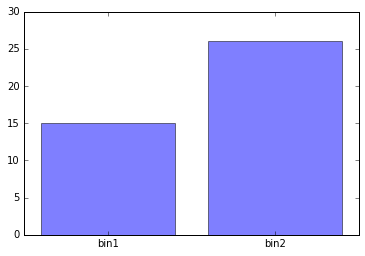

In [35]:
mu1 = 15.
mu2 = 26.
plt.bar([1,2], [mu1, mu2], align='center', alpha=0.5)
plt.xticks([1,2], ["bin1", "bin2"])

In [36]:
y1 = np.random.poisson(mu1, 10000)
y2 = np.random.poisson(mu2, 10000)

In [37]:
ll=[]
ll_const=[]
for i in range(10000):
    ll.append(-2*(LLR_P(mu1, y1[i])+LLR_P(mu2, y2[i])))
    ll_const.append(-2.*(LLR_P(mu1, y1[i])+LLR_P(mu2, y2[i])-0.5*(y1[i]-mu1)**2/4. - 0.5*(y2[i]-mu2)**2/4.))



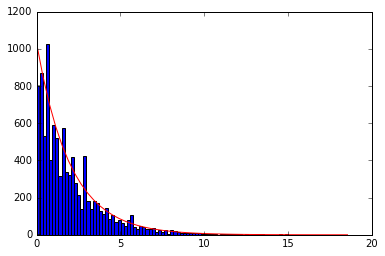

In [38]:
plt.figure()
ncounts, bins, patches = plt.hist(ll,100)
chiPDF=ss.chi2.pdf(np.linspace(min(ll),max(ll),50) , 2)
plt.plot(np.linspace(min(ll),max(ll),50), max(ncounts)*2.*chiPDF, c='r')

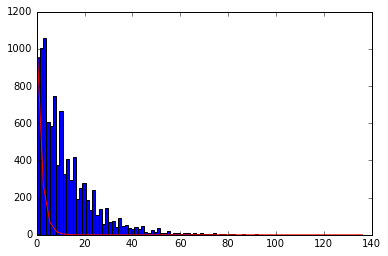

In [39]:
plt.figure()
ncounts, bins, patches = plt.hist(ll_const,100)
chiPDF=ss.chi2.pdf(np.linspace(min(ll_const),max(ll_const),50) , 2)
plt.plot(np.linspace(min(ll_const),max(ll_const),50), max(ncounts)*2.*chiPDF, c='r')

### Fitting noncentral chi2

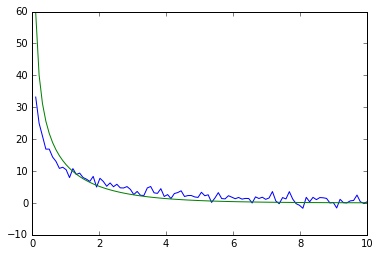

In [40]:
xs = np.linspace(0, 10, 100)
samp = np.random.randn(100)+(50*ss.ncx2.pdf(xs, 1., 1.2))
chi2 = 50*ss.chi2.pdf(xs,1)
plt.plot(xs, samp, c='b')
plt.plot(xs,chi2, c='g')

In [41]:
def ncchi(x, nc, amp):
    return amp*ss.ncx2.pdf(x, 1., nc)

In [42]:
bf_params, bf_cov = op.curve_fit(ncchi, xs[1:], samp[1:])
print bf_params

[  1.10046637  47.22260321]


### Fitting smooth distribution or smeared distribution

#### 3 param on atlas data

In [198]:
lnProb = logLike_3ff_minuit(xvalO,yvalO,xerrO)
bestval, best_fit_new = fit_3ff_minuit(100, lnProb)
bkg3param = model_3param(xvalO, best_fit_new, xerrO)
#nx = np.append(xvalO_low, xvalO)
#nxe = np.append(xerrO_low, xerrO)
#nxl = np.append(xlowO_low, xlowO)
asimov = model_3param(xvalO, best_fit_new, xerrO)

In [50]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

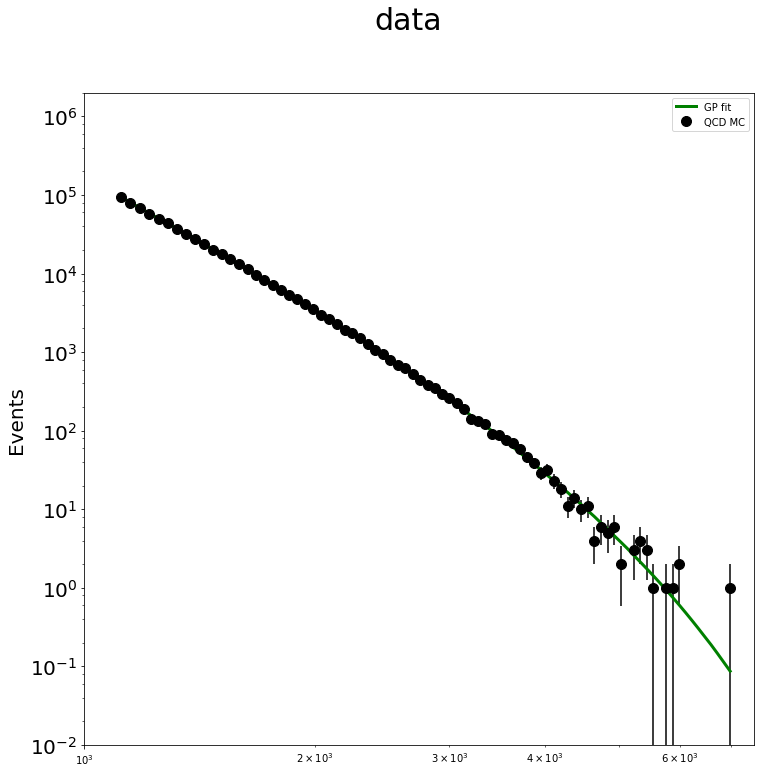

In [51]:
basicPlot(xvalO, yvalO, asimov, "data")

chi2 64.6654341756


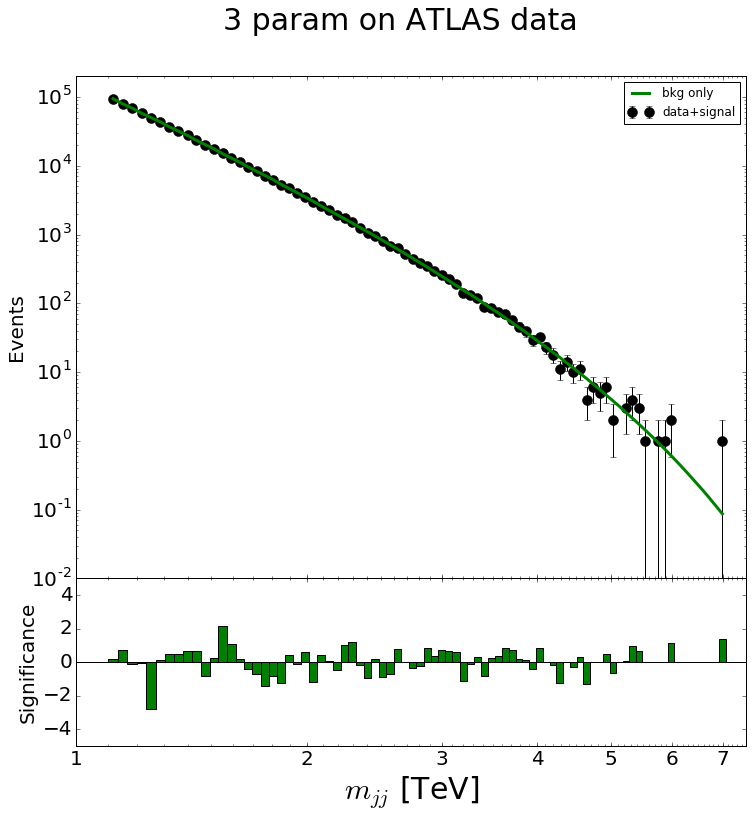

In [46]:
makePrettyPlots(xvalO, yvalO, asimov, "3 param on ATLAS data")

In [199]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix3p=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix3p[ip,:]= bkg
covMat3p = np.cov(modelMatrix3p.T)
corMat3p = np.corrcoef(modelMatrix3p.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01544162  8.26006651 -5.24797995]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


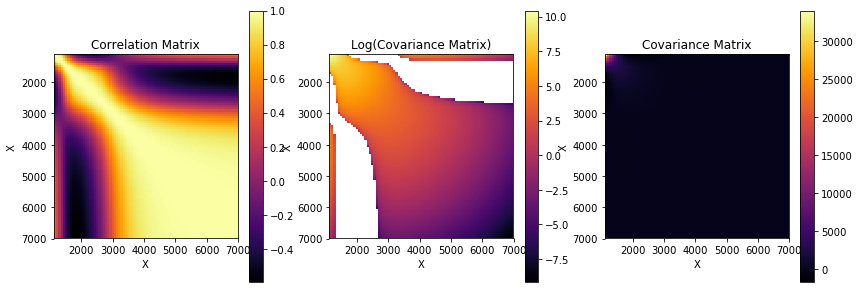

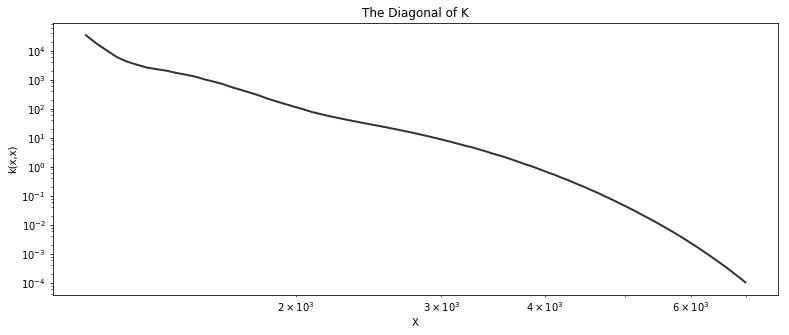

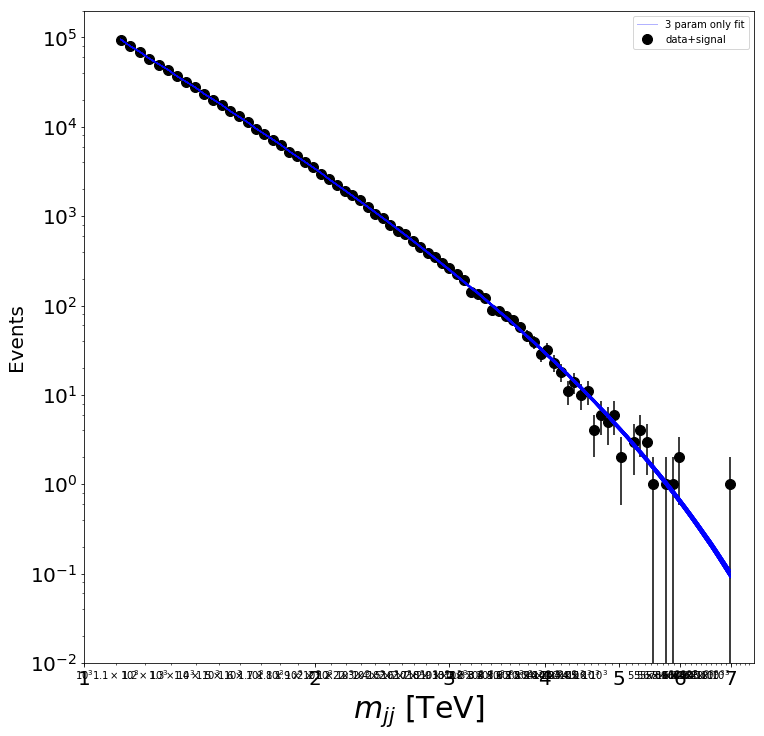

In [200]:
plot_cov(xvalO2D, corMat3p, covMat3p, False)
makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix3p[:100]).tolist(), "", ymax = 2e5)

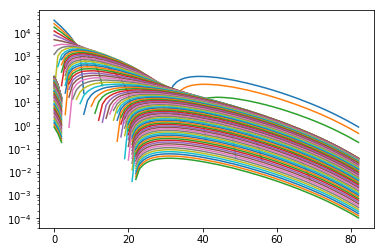

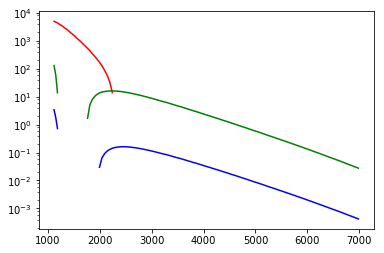

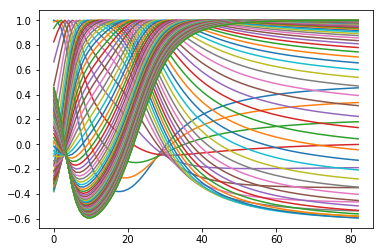

In [204]:
for i in range(len(covMat3p[1])):
    plt.plot(np.arange(len(covMat3p[1])),(covMat3p[i,:]))
plt.semilogy()
plt.figure()
plt.semilogy()
plt.plot(xvalO,(covMat3p[5,:]), c='r')
plt.plot(xvalO,(covMat3p[40,:]), c='g')
plt.plot(xvalO,(covMat3p[75,:]),c='b')
plt.figure()
for i in range(len(corMat3p[1])):
    plt.plot(np.arange(len(corMat3p[1])),(corMat3p[i,:]))

#### 3 param on smooth data

In [12]:
lnProb = logLike_3ff_minuit(xvalO, asimov ,xerrO)
bestval, best_fit_new = fit_3ff_minuit(100, lnProb)
smoothPs = best_fit_new
#background with best fit parameters
bkg3param = model_3param(xvalO, best_fit_new, xerrO)

#makePrettyPlots(xvalO, asimov, bkg3param, "3 param on smooth data")

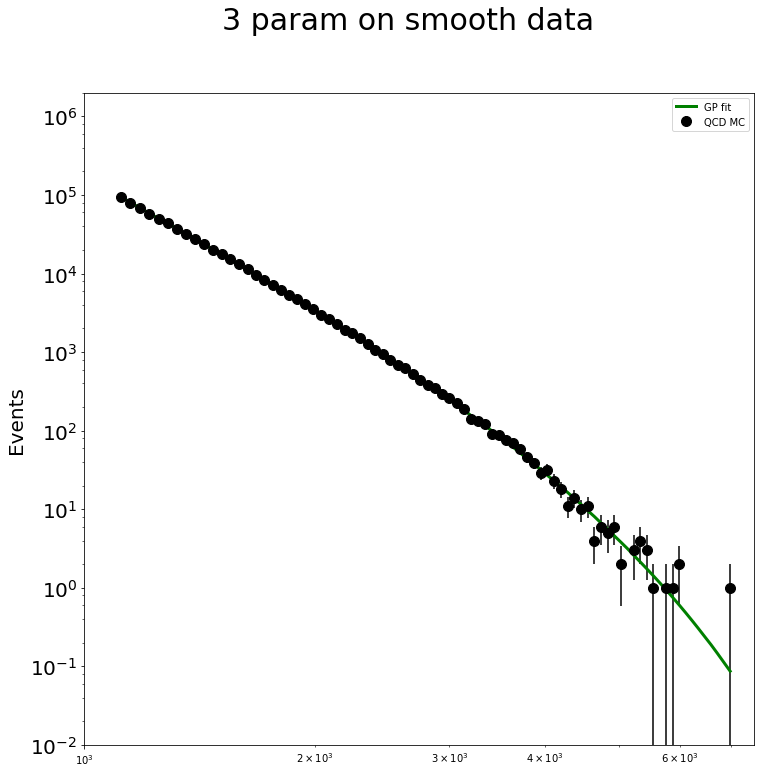

In [13]:
basicPlot(xvalO, yvalO, bkg3param, "3 param on smooth data")

In [50]:
def logLike_ind_smooth(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-asimov)*(bkgFunc-asimov) / bkgFunc) 

In [51]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind_smooth)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01662322  8.4415952  -5.22436125]


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log


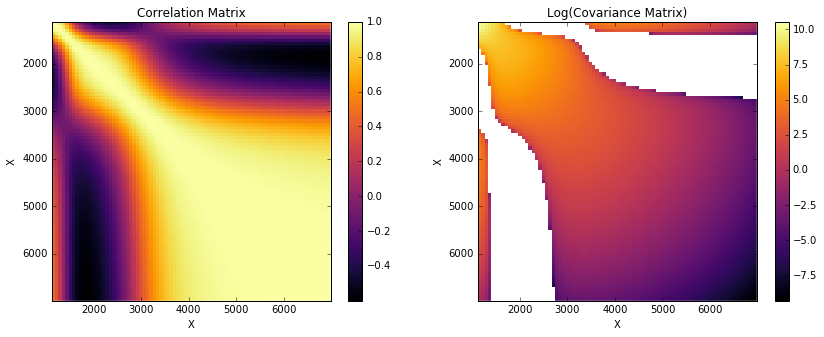

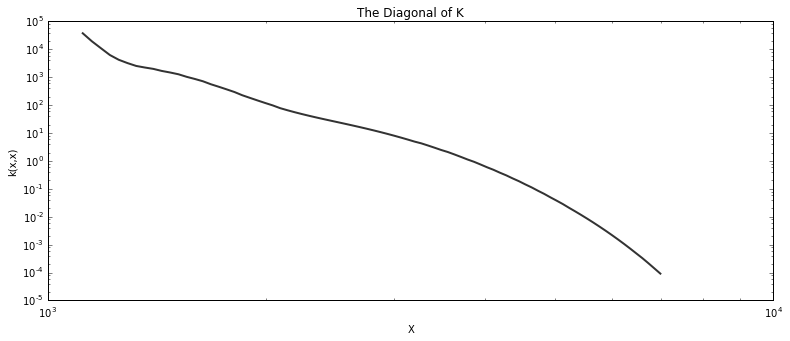

In [52]:
plot_cov(xvalO2D, corMat, covMat, False)

#### GP on atlas data

In [206]:
lnProb = logLike_gp_minuit(xval,yval, xerr)
bestval, hyperpso = fit_gp_minuit(100, lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperpso
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGP, covGP = gp.predict(yval - model_gp(hyperpso[5:],xval, xerr), xvalO)
meanGPnomO = meanGP+ model_3param(xvalO,hyperpso[5:],xerrO)

min LL 310.65062539
best fit vals (11605550.0217981, 174.97916530845063, 0.11497644115432415, -127.9667990922964, 82.05176867050437, 0.01745120260874089, 8.577059301311127, -5.206370227980615)


chi2 59.2057503491


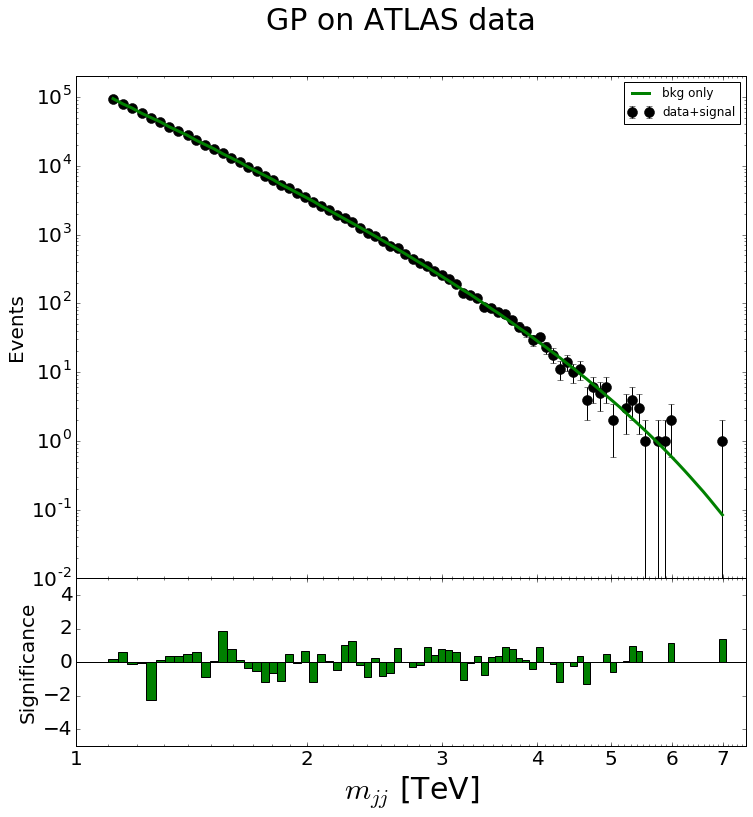

In [54]:
makePrettyPlots(xvalO, yvalO, meanGPnomO, "GP on ATLAS data")

In [207]:
samps = gp.sample_conditional(yval - model_gp(hyperpso[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrixgp=np.empty([samps.shape[0], xvalO.size])
print modelMatrixgp.shape
for ip, ps in enumerate(samps):
    modelMatrixgp[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMatgp = np.cov(modelMatrixgp.T)
corMatgp = np.corrcoef(modelMatrixgp.T)

(1000, 83)
(1000, 83)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


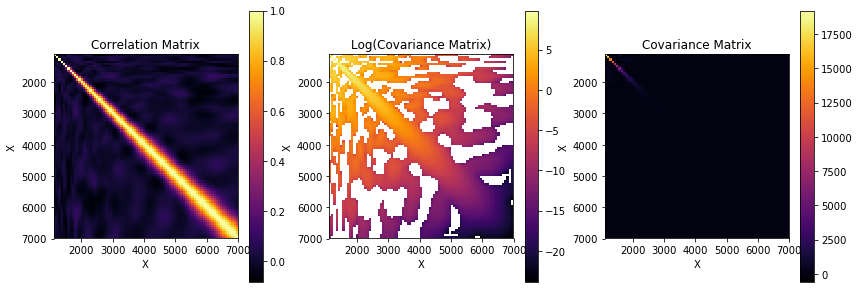

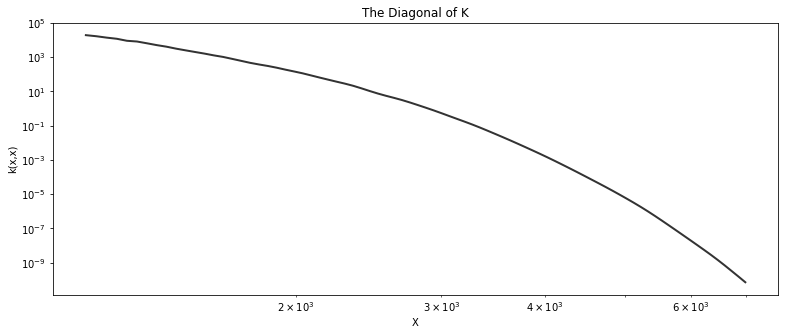

In [215]:
plot_cov(xvalO2D, corMatgp, covMatgp, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgp[:100]).tolist(), "", ymax = 2e5)

In [3]:
for i in range(len(covMatgp[1])):
    plt.plot(np.arange(len(covMatgp[1])),(covMatgp[i,:]))
plt.semilogy()
plt.figure()
plt.semilogy()
plt.plot(xvalO,(covMatgp[5,:]), c='r')
plt.plot(xvalO,(covMatgp[40,:]), c='g')
plt.plot(xvalO,(covMatgp[75,:]),c='b')
plt.figure()
for i in range(len(corMatgp[1])):
    plt.plot(np.arange(len(corMatgp[1])),(corMatgp[i,:]))

NameError: name 'covMatgp' is not defined

#### GP on smooth data

In [57]:
lnProb = logLike_gp_minuit(xvalO,asimov, xerrO)
bestval, hyperps = fit_gp_minuit(100, lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperps
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xvalO, np.sqrt(asimov))
meanGP, covGP = gp.predict(asimov - model_gp(hyperps[5:],xvalO, xerrO), xvalO)
meanGPnom = meanGP+ model_3param(xvalO,hyperps[5:],xerrO)

min LL 287.874528723
best fit vals (10884252.72213191, 56.31252345485726, 1.0762026998733187, 87.92428253567516, 40.4128850818431, 0.01609110339353237, 8.383027180423255, -5.232684807195119)


chi2 1.13863831953e-07


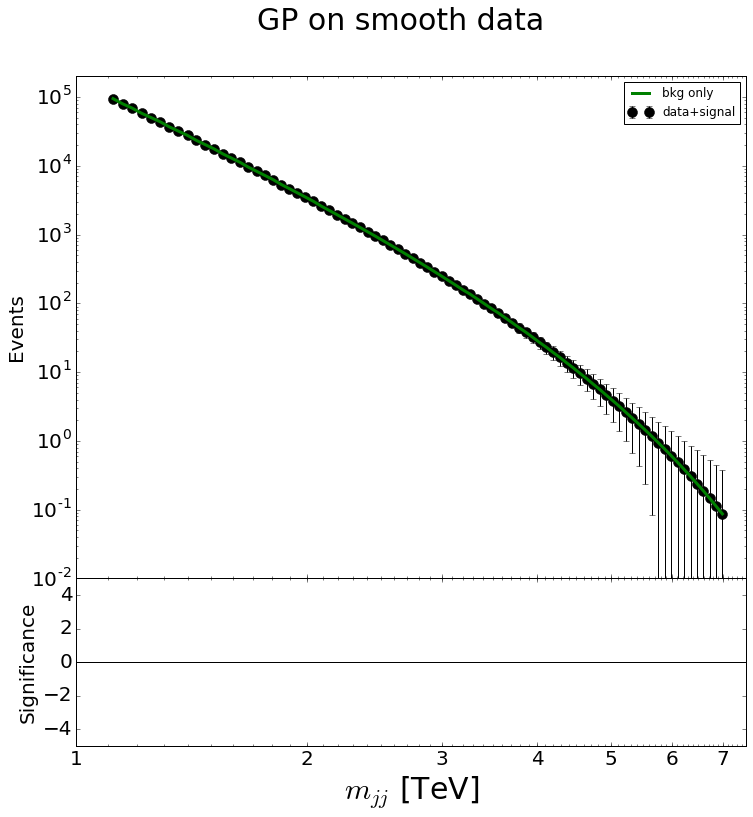

In [58]:
makePrettyPlots(xvalO, asimov, meanGPnom, "GP on smooth data")

In [59]:
samps = gp.sample_conditional(asimov - model_gp(hyperps[5:],xvalO, xerrO), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperps[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

(1000, 83)
(1000, 83)


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log


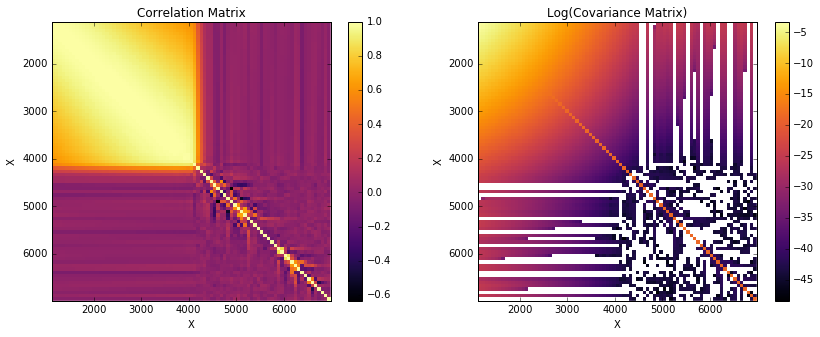

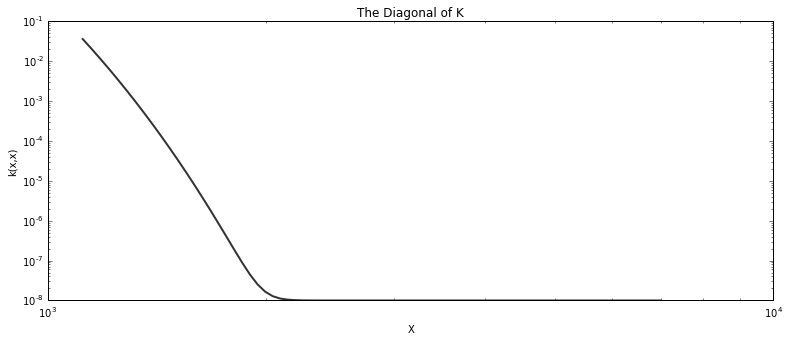

In [60]:
plot_cov(xvalO2D, corMat, covMat, False)

In [121]:
def makePrettyPlots_bkgFits(xs, xv, ys, bkgFits, title, ymax = 2e5): #gpFits
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xv, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal", zorder=1)
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot_3, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit", zorder=2)
        else:
            bkgPlot_3 =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, zorder=3)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### smeared

### swift

In [175]:
'''
def logLike_ind_swift(p, yvals, xvals, xerrs):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvals, p, xerrs)
    return -0.5 * np.sum( (bkgFunc-yvals)*(bkgFunc-yvals) / bkgFunc)
'''



modelMatrix0=np.zeros([xvalO.size, xvalO.size])

for wi, w in enumerate(xvalO):
    print wi
    if wi < 10: 
        print "under"
        wmin = 0
    else: wmin = wi-10
    if wi > xvalO.size-10: 
        print "over"
        wmax = xvalO.size
    else: wmax = wi+30
    print w, wmin, wmax
    xvals = xvalO[wmin:wmax]
    xerrs = xerrO[wmin:wmax]
    yvals = yvalO[wmin:wmax]

    lnProb = logLike_3ff_minuit(xvals,yvals,xerrs)
    bestval, best_fit_new = fit_3ff_minuit(100, lnProb)

    modelMatrix0[wi,wmin:wmax] = model_3param(xvals,best_fit_new,xerrs)


        
covMat0 = np.cov(modelMatrix0.T)
corMat0 = np.corrcoef(modelMatrix0.T)




0
under
1116.5 0 30
1
under
1149.5 0 31
2
under
1183.0 0 32
3
under
1217.0 0 33
4
under
1251.5 0 34
5
under
1287.0 0 35
6
under
1323.0 0 36
7
under
1359.5 0 37
8
under
1397.0 0 38
9
under
1435.0 0 39
10
1473.5 0 40
11
1513.0 1 41
12
1553.0 2 42
13
1593.5 3 43
14
1635.0 4 44
15
1677.0 5 45
16
1719.5 6 46
17
1763.0 7 47
18
1807.5 8 48
19
1852.5 9 49
20
1898.0 10 50
21
1944.5 11 51
22
1992.0 12 52
23
2040.5 13 53
24
2089.5 14 54
25
2139.0 15 55
26
2189.5 16 56
27
2241.0 17 57
28
2293.5 18 58
29
2347.0 19 59
30
2401.5 20 60
31
2457.0 21 61
32
2513.5 22 62
33
2571.0 23 63
34
2629.5 24 64
35
2689.0 25 65
36
2749.5 26 66
37
2811.0 27 67
38
2873.5 28 68
39
2937.0 29 69
40
3001.5 30 70
41
3067.0 31 71
42
3133.5 32 72
43
3201.0 33 73
44
3270.0 34 74
45
3340.5 35 75
46
3412.0 36 76
47
3484.5 37 77
48
3558.5 38 78
49
3634.0 39 79
50
3710.5 40 80
51
3788.0 41 81
52
3867.0 42 82
53
3947.5 43 83
54
4029.0 44 84
55
4112.0 45 85
56
4196.5 46 86
57
4282.5 47 87
58
4370.0 48 88
59
4459.0 49 89
60
4549.5 

In [1]:
#plot_cov(np.arange(0,len(xvalO),1).reshape(-1,1), corMat0, covMat0, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix0).tolist(), "", ymax = 2e5)
plt.figure()
m = plt.imshow(covMat0[50:][50:], cmap="inferno",
                   interpolation='none',
                   extent=(1, 10, 10, 1))
plt.colorbar(m)

NameError: name 'plt' is not defined

### smearing width
nx = np.append(xvalO_low, xvalO)
nxe = np.append(xerrO_low, xerrO)
nxl = np.append(xlowO_low, xlowO)

In [163]:
####run for many shifts and widths of guassian
zs=np.arange(nxl[0], nxl[-1], 1)
steps = 10.*np.random.randn(50)+100.
xs=nx
modelMatrixi=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothPs,zer)
            gaus = ss.norm.pdf(x, z, b)
            newycounts[xi]+=pz*gaus*nxe[xi] 
    modelMatrixi[bi,:]= newycounts
    #print modelMatrix



0 115.875537814
1 114.282673671
2 107.911283419
3 106.84958468
4 121.800046374
5 103.686568136
6 91.5908874308
7 108.629544141
8 88.1113628683
9 105.295573162
10 104.400449188
11 99.5264880659
12 91.8746751607
13 97.2683720936
14 96.4175424512
15 94.3842552592
16 119.065470839
17 102.348897537
18 80.4323025626
19 85.3503474153
20 104.698351764
21 105.542147889
22 99.2947067179
23 111.352975695
24 106.172221453
25 92.7812313738
26 97.3059305685
27 104.437989424
28 95.361836358
29 101.5907964
30 109.580946315
31 110.94273541
32 91.8360156299
33 102.786871254
34 121.150727182
35 101.901246608
36 91.1476386223
37 127.656874172
38 125.035301455
39 113.675661965
40 88.150721721
41 94.96470078
42 86.1947941587
43 98.084261598
44 82.189498468
45 103.743344025
46 85.1400273096
47 112.899570816
48 113.795503754
49 106.556308315


[[  1.18667468e+05   9.91214672e+04   8.51455592e+04 ...,   1.50610317e-01
    1.13377551e-01   7.12327784e-02]
 [  1.18059928e+05   9.85630602e+04   8.46517899e+04 ...,   1.50507427e-01
    1.13421245e-01   7.12911924e-02]
 [  1.15611759e+05   9.63707446e+04   8.27464448e+04 ...,   1.50099459e-01
    1.13593188e-01   7.15858112e-02]
 ..., 
 [  1.17530142e+05   9.80809780e+04   8.42283931e+04 ...,   1.50418336e-01
    1.13459114e-01   7.13467170e-02]
 [  1.17873526e+05   9.83929354e+04   8.45020753e+04 ...,   1.50476018e-01
    1.13434598e-01   7.13102344e-02]
 [  1.15091185e+05   9.59156045e+04   8.23569530e+04 ...,   1.50013649e-01
    1.13628393e-01   7.16617455e-02]]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


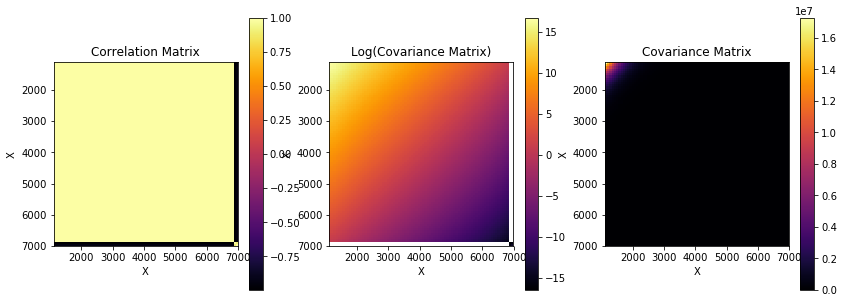

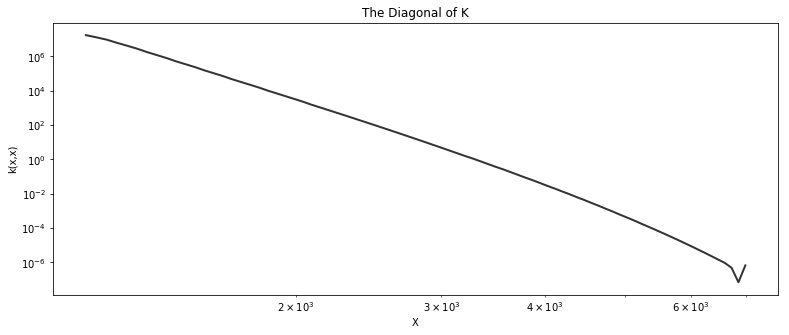

In [174]:
print modelMatrixi[:,11:]
h2=modelMatrixi[:,11:].T
covMati = np.cov(h2)
corMati = np.corrcoef(h2)

plot_cov(nx[11:].reshape(-1,1), corMati, covMati, False)

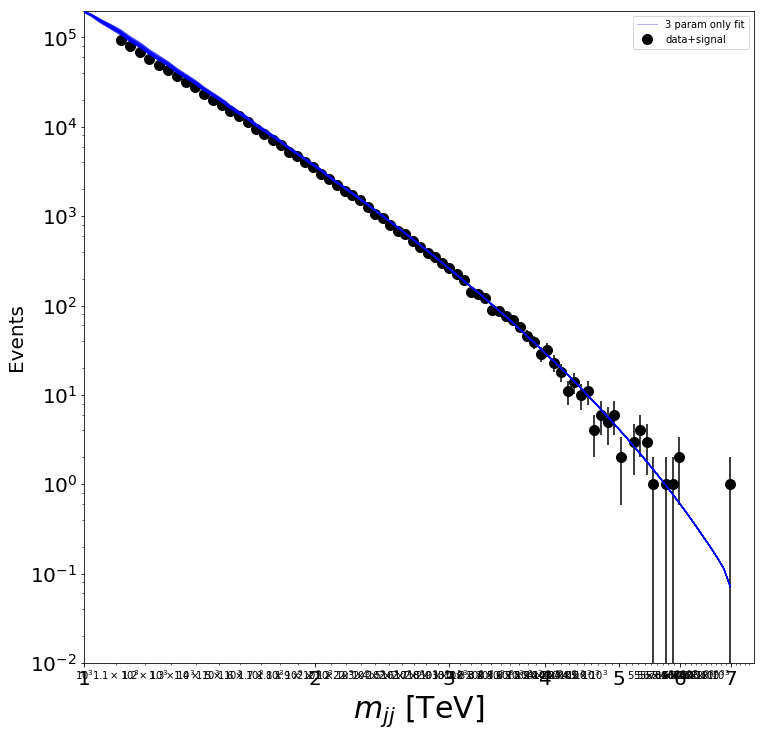

In [123]:
makePrettyPlots_bkgFits(nx, xvalO, yvalO, (modelMatrix).tolist(), "", ymax = 2e5)

### smearing width uniform binning

In [91]:
zs=np.arange(nxl[0], nxl[-1], 1)
#zs=np.arange(xlowO[0], xlowO[-1], 1)
steps = 10.*np.random.randn(50)+100.
xs = np.arange(xlowO[0], xlowO[-1],10)
#xs=xvalO
#xs=nx
modelMatrix5=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothPs,zer)
            gaus = ss.norm.pdf(x, z, b)
            newycounts[xi]+=pz*gaus*10.
    modelMatrix5[bi,:]= newycounts 

covMat5 = np.cov(modelMatrix5[:,11:])
corMat5 = np.corrcoef(modelMatrix5[:,11:])

plot_cov(nx[11:].reshape(-1,1), corMat5, covMat5, False)

0 -14.3667056715
1 -81.4600713293


KeyboardInterrupt: 

### smearing mean

In [94]:
nx = np.append(xvalO_low, xvalO)
nxe = np.append(xerrO_low, xerrO)
nxl = np.append(xlowO_low, xlowO)

zs=np.arange(nxl[0], nxl[-1], 1)
#zs=np.arange(xlowO[0], xlowO[-1], 1)
steps = 10.*np.random.randn(50)
#xs = np.arange(xlowO[0], xlowO[-1],10)
#xs=xvalO
xs=nx
modelMatrix3=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothPs,zer)
            gaus = ss.norm.pdf(x, z+b, 100.)
            newycounts[xi]+=pz*gaus*nxe[xi] #xerrO[xi] #10.
    modelMatrix3[bi,:]= newycounts  

0 -7.35547312663
1 -5.35360468953
2 5.49600998484
3 -15.317620143
4 -10.6911823229
5 -1.57113330199
6 -8.92634762884
7 -6.83641087248
8 0.617844944801
9 -11.6211607288
10 -2.42946586766
11 0.813550880348
12 10.4676711064
13 18.3190667534
14 -1.94565508806
15 -8.07439912077
16 -16.2713749927
17 2.20432861159
18 -14.5759928425
19 -2.55819179801
20 -3.41187294175
21 9.62373380782
22 9.25705229019
23 0.627966482851
24 8.79457187566
25 25.9326982477
26 5.72206147569
27 -1.81550010784
28 -11.8744933018
29 -0.0176150199246
30 -5.36298218146
31 -1.31766536859
32 -2.58321336257
33 2.61769666237
34 -7.90621141203
35 10.1708385565
36 8.1069648444
37 3.99354634487
38 1.25150417973
39 6.33395490537
40 11.4802251133
41 -1.52743077491
42 -1.64940293522
43 18.54931072
44 2.08906267592
45 3.80837327406
46 -1.17468369126
47 4.05854772563
48 -2.33857632139
49 -4.70791687188


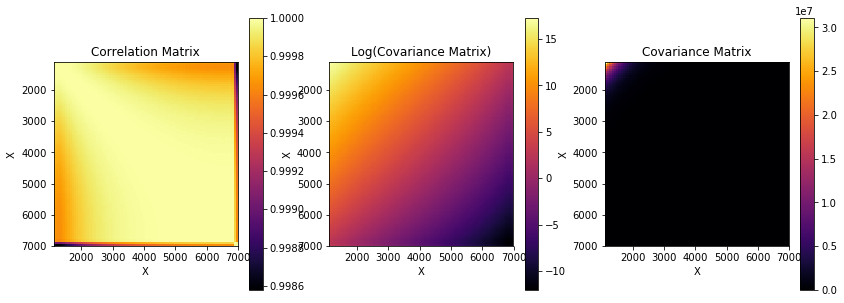

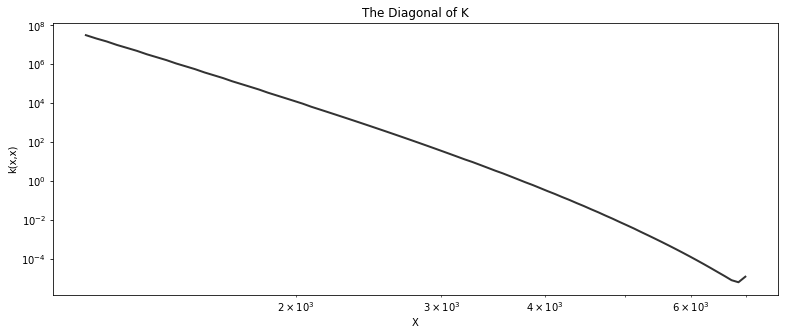

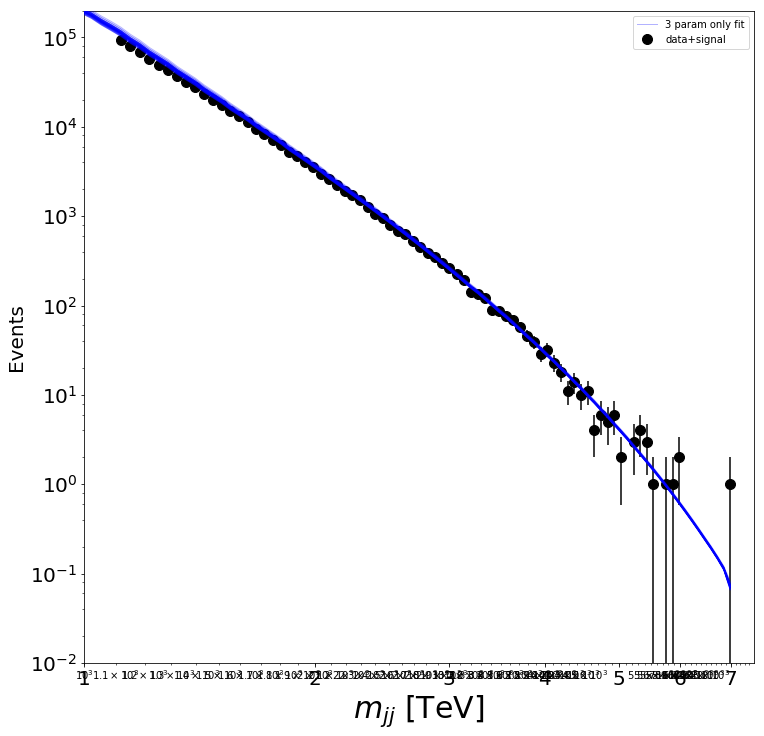

In [124]:
covMat3 = np.cov(modelMatrix3[:,11:].T)
corMat3 = np.corrcoef(modelMatrix3[:,11:].T)
plot_cov(nx[11:].reshape(-1,1), corMat3, covMat3, False)
makePrettyPlots_bkgFits(nx, xvalO, yvalO, (modelMatrix3).tolist(), "", ymax = 2e5)

### other smearing mean larger

In [ ]:
zs=np.arange(nxl[0], nxl[-1], 1)
steps = 100.*np.random.randn(50)
xs=nx
modelMatrix4=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothPs,zer)
            gaus = ss.norm.pdf(x, z+b, 100.)
            newycounts[xi]+=pz*gaus*nxe[xi] 
    modelMatrix4[bi,:]= newycounts 
covMat4 = np.cov(modelMatrix4[:,11:-1].T)
corMat4 = np.corrcoef(modelMatrix4[:,11:-1].T)
plot_cov(nx[11:-1].reshape(-1,1), corMat4, covMat4, False)

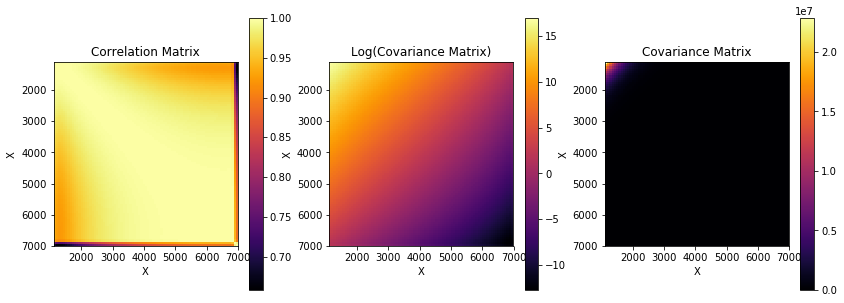

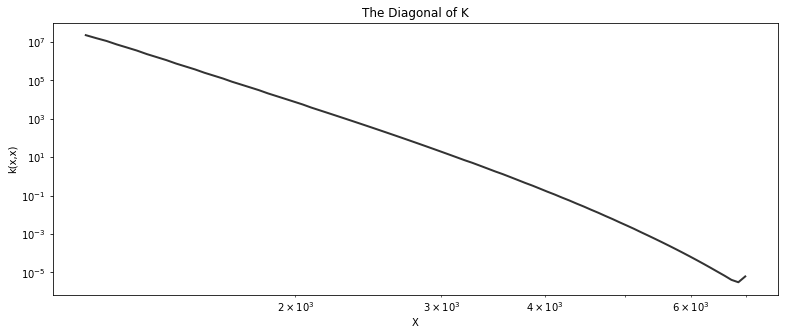

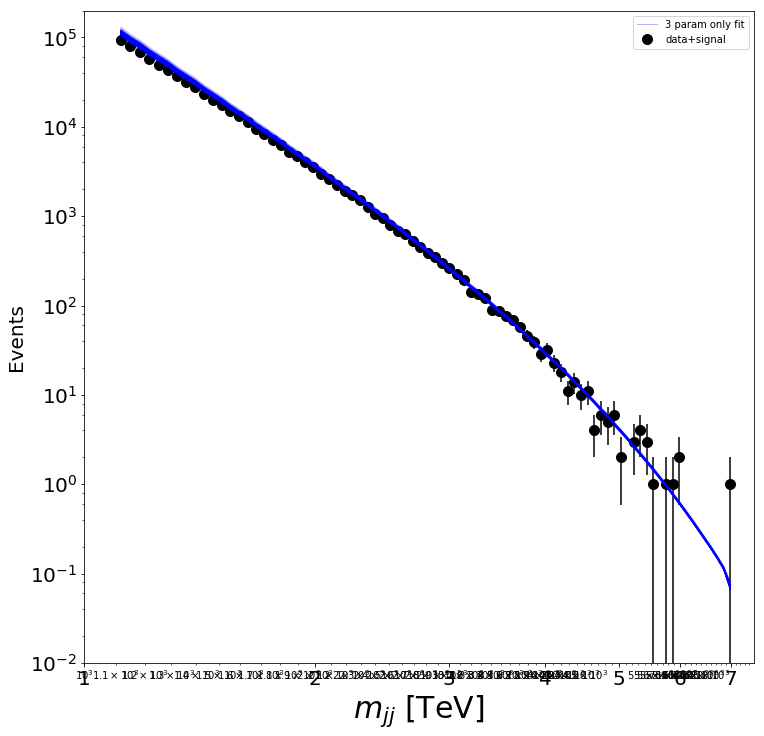

In [126]:

mm = np.append(modelMatrix[:,11:], modelMatrix3[:,11:], axis=0)
covMatComb = np.cov(mm.T)
corMatComb = np.corrcoef(mm.T)
plot_cov(nx[11:].reshape(-1,1), corMatComb, covMatComb, False)
makePrettyPlots_bkgFits(nx[11:], xvalO, yvalO, (mm).tolist(), "", ymax = 2e5)

### PDF

[260.0, 310.0, 370.0, 440.0, 510.0, 590.0, 670.0, 760.0, 850.0, 950.0, 1060.0, 1180.0, 1310.0, 1450.0, 1600.0, 1760.0, 1940.0, 2120.0, 2330.0, 2550.0, 2780.0]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


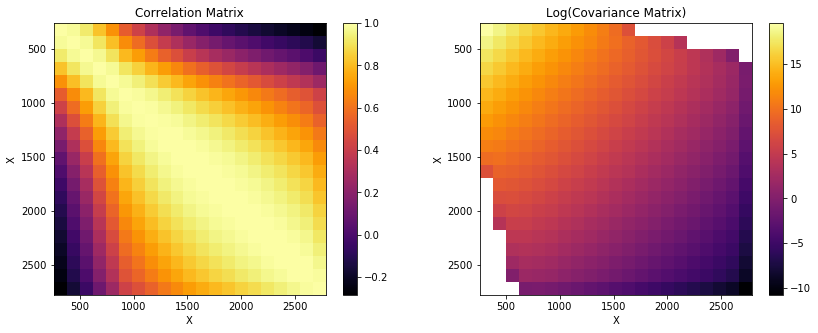

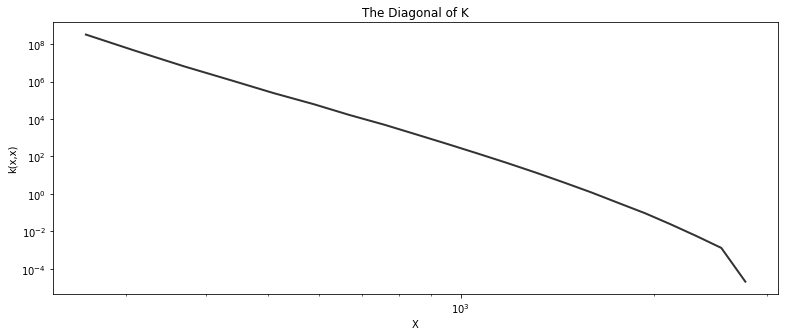

In [81]:
covMat = open("../Downloads/covariancePDF", "r")
bins = open("../Downloads/bins", "r")
binlines = bins.readlines()
newbins=[]
for ib, bl in enumerate(binlines):
    nwl=bl.split(" ")
    newbins.append(float(nwl[1]))
    #newbins.append(float(nwl[2]))
newbins.sort()    
print newbins
covMatPDF= np.zeros((len(newbins),len(newbins)))
corMatPDF= np.zeros((len(newbins),len(newbins)))
lines = covMat.readlines()
for il, line in enumerate(lines):
    line = [float(l) for l in line.split(" ")]
    #print line
    covMatPDF[il,:]=line

for i in range(len(newbins)):
    for j in range(len(newbins)):
        corMatPDF[i][j]=covMatPDF[i][j]/np.sqrt(covMatPDF[i][i]*covMatPDF[j][j])



/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


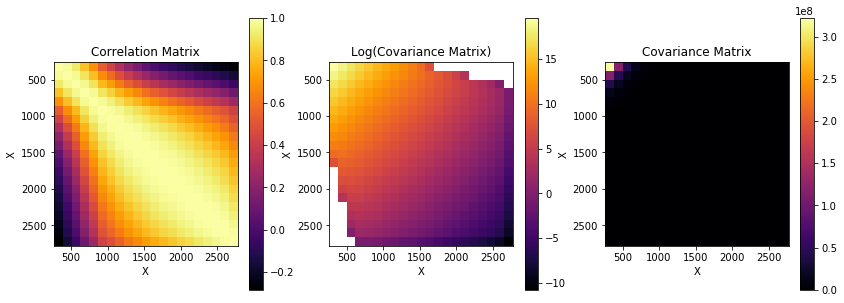

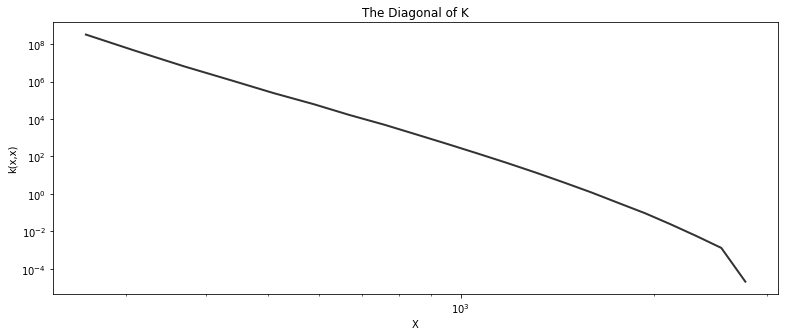

In [119]:
plot_cov(np.array(newbins).reshape(-1,1), corMatPDF, covMatPDF, False)

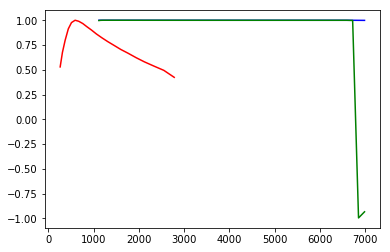

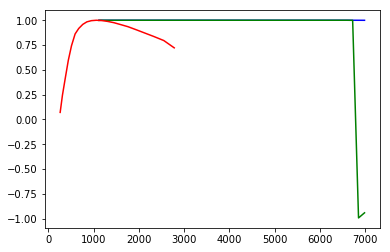

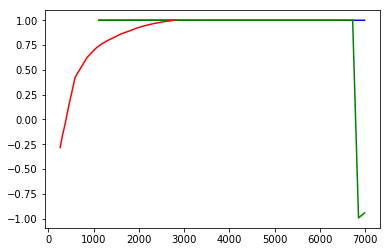

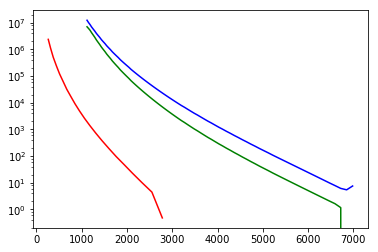

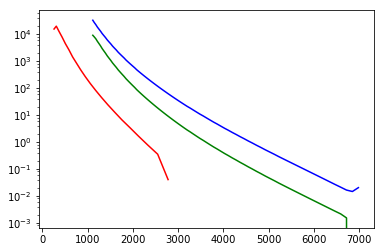

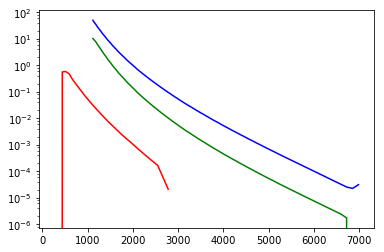

In [179]:
plt.plot(xvalO,corMat3[5,:], label="JES",c='b')
plt.plot(xvalO,corMati[5,:], label="resolution", c='g')
plt.plot(newbins,corMatPDF[5,:], label="PDF", c= 'r')

plt.figure()
plt.plot(xvalO,corMat3[40,:],label="JES",c='b')
plt.plot(xvalO,corMati[40,:], label="resolution", c='g')
plt.plot(newbins,corMatPDF[10,:],label="PDF", c= 'r')

plt.figure()
plt.plot(xvalO,corMat3[75,:],label="JES",c='b')
plt.plot(xvalO,corMati[75,:], label="resolution", c='g')
plt.plot(newbins,corMatPDF[20,:], label="PDF", c= 'r')

plt.figure()
plt.plot(xvalO,covMat3[5,:],label="JES",c='b')
plt.plot(xvalO,covMati[5,:], label="resolution", c='g')
plt.plot(newbins,covMatPDF[5,:], label="PDF", c= 'r')
plt.yscale('log')

plt.figure()
plt.plot(xvalO,covMat3[40,:],label="JES",c='b')
plt.plot(xvalO,covMati[40,:], label="resolution", c='g')
plt.plot(newbins,covMatPDF[10,:], label="PDF", c= 'r')
plt.yscale('log')
plt.figure()
plt.plot(xvalO,covMat3[75,:],label="JES",c='b')
plt.plot(xvalO,covMati[75,:], label="resolution", c='g')
plt.plot(newbins,covMatPDF[20,:], label="PDF", c= 'r')
plt.yscale('log')
#for i in range(len(corMat[1])):
#    plt.plot(np.arange(len(corMat[1])),(corMat[i,:]))

### GP smeared

In [ ]:

lnProb = logLike_gp_minuit(smearedx,smearedy, smearedxerr)
bestval, hyperps2 = fit_gp_minuit(100, lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperps2
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(smearedx, np.sqrt(smearedy))


In [ ]:
meanGP2, covGP = gp.predict(smearedy - model_gp(hyperps2[5:],smearedx, smearedxerr), xvalO)
meanGPnom2 = meanGP2 + model_3param(xvalO,hyperps2[5:],xerrO)

In [ ]:
makePrettyPlots(xvalO, newycounts[3:], meanGPnom2, "GP smeared")

In [ ]:
samps = gp.sample_conditional(smearedy - model_gp(hyperps2[5:],smearedx, smearedxerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperps2[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

In [ ]:
plot_cov(xvalO2D, corMat, covMat, False)

### fit function smeared

In [ ]:
def logLike_ind_smear(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    print newycounts[20]
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-newycounts[3:])*(bkgFunc-newycounts[3:]) / bkgFunc) 

In [ ]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind_smear)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

In [ ]:
plot_cov(xvalO2D, corMat, covMat, False)

In [ ]:
#############

In [ ]:
newycounts=np.zeros(len(asimov))
for ix, y in enumerate(asimov):
    print "y", y
    smeared = nxe[ix]*np.random.randn(int(y))+nx[ix]
    for xnew in smeared:
        for ixl in range(len(nxl)):
            if xnew > nxl[ixl] and xnew < nxl[ixl+1]:
                newycounts[ixl]+=1
    print newycounts[ix]
smearedy, smearedx, smearedxerr = removeZeros(newycounts[3:])

In [ ]:
lnProb = logLike_gp_minuit(smearedx,smearedy, smearedxerr)
bestval, hyperps2 = fit_gp_minuit(100, lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperps2
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(smearedx, np.sqrt(smearedy))

meanGP2, covGP = gp.predict(smearedy - model_gp(hyperps2[5:],smearedx, smearedxerr), xvalO)
meanGPnom2 = meanGP2 + model_3param(xvalO,hyperps2[5:],xerrO)
makePrettyPlots(xvalO, newycounts[3:], meanGPnom2, "GP smeared")

In [ ]:
samps = gp.sample_conditional(smearedy - model_gp(hyperps2[5:],smearedx, smearedxerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperps2[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)
plot_cov(xvalO2D, corMat, covMat, False)

In [ ]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind_smear)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)
plot_cov(xvalO2D, corMat, covMat, False)